# Preprocessing

In [1]:
import pickle
import json
import os
from preprocessing import clean_gt, clean_raw, label_entity

In [2]:
split = pickle.load(open('data/train_test_eval_filenames_new.pkl', 'rb'))
# split

In [3]:
#train = 94, test = 30, eval = 10

In [4]:
# import random
# new_split = {"train":[], "test": [], "eval": []}
# for key in split:
#     for page in split[key]:
#         mag = page.split("_")[0].split("-")[0]
#         year = page.split("_")[1]
        
#         if mag == "dkm" and (year == "1941" or year == "2010"):
#             new_split["train"].append(page)
#         if (year == "1990"):
#             new_split["test"].append(page)
#         if mag =="sbz" and (year == "1895" or year == "1940" or year == "1965" or year == "2010"):
#             new_split["train"].append(page)

# eval_set = random.sample(new_split["train"], int(len(new_split["train"])/10)) #set 10% of train aside for eval
# for page in eval_set:
#     new_split["train"].remove(page)
# new_split["eval"] = eval_set

# with open('train_test_eval_filenames_new.pkl', 'wb') as out:
#     pickle.dump(new_split, out)

In [ ]:
"""
data = {
    "train": [],
    "test": [],
    "eval": []
}
gt_data = []
for mag in ["dkm", "sbz"]:
    for year in os.listdir(f'data/raw/link/{mag}'):
        with open(os.path.join("data/raw/link", mag, year)) as f:
            input_linked = json.load(f)
        with open(os.path.join("data/ground-truth", mag, year)) as f:
            gt = json.load(f)
        gt = clean_gt(gt)
        gt_data += gt
        input_linked = clean_raw(input_linked)

        #due to non-determinism in the flair NER:
        all_refs_gt = [g["page"]+g["coord"] for g in gt] 
        all_refs_linked = [ent["page"]+ent["coord"] for l in input_linked for ent in l]
        all_valid_refs = set(all_refs_gt).intersection(set(all_refs_linked))

        for ent_variations in input_linked:
            for key in split:
                ent_instances = []
                for ent in ent_variations:
                    if ent["page"] in split[key]:
                        if (ent["page"]+ent["coord"]) in all_valid_refs:
                            ent_instances.append({"ent": ent, "label": label_entity(ent, gt)})
                if ent_instances:
                    data[key].append(ent_instances)
"""

In [5]:
"""
with open("data/processed.pkl", "wb") as f:
    pickle.dump(data, f)
"""

# Candidate Generation

In [8]:
import pickle
from tqdm.notebook import  tqdm
from candidate_generation import create_metagrid_candidates, get_candidates_fuseki

In [ ]:
# load everytime you run this as we pop keys to keep data clean..
with open("data/processed.pkl", "rb") as f:
    data = pickle.load(f)

for split in ["train", "eval", "test"]:
    ent_cand_label = []
    i = 0
    for entity_list in tqdm(data[split], smoothing=0.01):
        i += 1
        # Create candidates only for the first entry in the list as all the entity information is always the same
        # The only thing that changes are pages and page_coordinates
        candidates = create_metagrid_candidates(ent=entity_list[0]["ent"])
        # Generate the list of page_coordinates and the corresponding labels!
        coord_list = []
        label_list = []
        for ent_dict in entity_list:
            ent = ent_dict["ent"]
            coord_list.append({
                "page": ent.pop("page", ""), 
                "coords": ent.pop("coord", "")
            })
            label_list.append(ent_dict["label"])
        ent_cand_label.append({"entity": ent, "candidates": candidates, "occurences": coord_list, "labels": label_list})
        if i % 100 == 0:
            with open(f"candidates-gnd-{split}.pkl", "wb") as f:
                pickle.dump(ent_cand_label, f)
                    
    with open(f"candidates-gnd-{split}.pkl", "wb") as f:
        pickle.dump(ent_cand_label, f)

  0%|▎                                                                                                                                                    | 1/574 [00:00<01:02,  9.10it/s]

# Feature Generation

### To get the relevant fastttext model uncomment and run the following cell

In [ ]:
# from gensim.models.fasttext import FastText, load_facebook_vectors
# model = load_facebook_vectors("cc.de.300.bin/cc.de.300.bin")
# model.save("./fasttext")

In [9]:
import pickle
from tqdm.notebook import  tqdm
from feature_generation import candidates_to_features, process_fuseki_candidates
from candidate_generation import create_metagrid_candidates, get_candidates_fuseki

In [10]:
#AF:
from tqdm import tqdm
# load everytime you run this as we pop keys to keep data clean..
with open("data/processed.pkl", "rb") as f:
    data = pickle.load(f)

problematic_entities = []
for split in ["train", "eval", "test"]:
    ent_cand_label = []
    i = 0
    for entity_list in tqdm(data[split], smoothing=0.01):
        i += 1
        # Create candidates only for the first entry in the list as all the entity information is always the same
        # The only thing that changes are pages and page_coordinates
        
        # fuseki:
        unique_candidate_dict = get_candidates_fuseki(entity_list[0]["ent"])
        candidates = process_fuseki_candidates(unique_candidate_dict)
        #print(process_fuseki_candidates(unique_candidate_dict))
        #list_of_tuples.append((ent, processed_fuseki_cands, ent_dict["label"]))
        
        #metagrid
        ## candidates = create_metagrid_candidates(ent=entity_list[0]["ent"])
        # Generate the list of page_coordinates and the corresponding labels!
        coord_list = []
        gt_label = []
        for ent_dict in entity_list:
            ent = ent_dict["ent"]
            coord_list.append({
                "page": ent.pop("page", ""), 
                "coords": ent.pop("coord", "")
            })
            gt_label.append(ent_dict["label"])

        #if len(gt_label)!=1:
        #    problematic_entities.append({"ent_list": entity_list, "gt_labels": gt_label, "mag": coord_list})
        #gt_label = gt_label.pop()
        
        ent_cand_label.append({"entity": ent, "candidates": candidates, "occurences": coord_list, "gt_label": gt_label})
        if i % 100 == 0:
            with open(f"data/candidates/candidates-gnd-{split}-{i}.pkl", "wb") as f:
                pickle.dump(ent_cand_label, f)
                    
    with open(f"data/candidates/candidates-gnd-{split}.pkl", "wb") as f:
        pickle.dump(ent_cand_label, f)
print(problematic_entities)


  0%|                                                                                                                                                             | 0/574 [00:00<?, ?it/s]

['']
['C*']
['Andres-Schurter']
C* AND Andres-Schurter
sucessfully linked


  1%|█▌                                                                                                                                                   | 6/574 [00:20<32:16,  3.41s/it]

['Christoph']
[]
['Bernoulli']
Christoph AND Bernoulli
sucessfully linked


  1%|██                                                                                                                                                   | 8/574 [00:25<29:48,  3.16s/it]

['Appenzellem']
[]
['Breitenmoser']
Appenzellem AND Breitenmoser
results is empty
Appenzellem AND Breitenmoser
['Armin']
[]
['Broger']
Armin AND Broger


  2%|██▎                                                                                                                                                  | 9/574 [00:25<26:38,  2.83s/it]

sucessfully linked
['Boger']
[]
['Dörig']
Boger AND Dörig


  2%|██▌                                                                                                                                                 | 10/574 [00:25<24:02,  2.56s/it]

results is empty
Boger AND Dörig
['Agnes']
[]
['Farner-Hasler']
Agnes AND Farner-Hasler


  2%|██▊                                                                                                                                                 | 11/574 [00:25<21:56,  2.34s/it]

results is empty
Agnes AND Farner-Hasler
['Franz', 'Anton']
[]
['Heim']
Franz AND Anton AND Heim
sucessfully linked


  2%|███                                                                                                                                                 | 12/574 [00:26<20:10,  2.15s/it]

['Gertrud']
[]
['Haemmerli-Schindler']
Gertrud AND Haemmerli-Schindler
sucessfully linked


  3%|███▊                                                                                                                                                | 15/574 [00:27<16:32,  1.78s/it]

['Johann', 'Jacob']
[]
['Iieuscher']
Johann AND Jacob AND Iieuscher
results is empty
Johann AND Jacob AND Iieuscher
['']
['P*']
['Jaberg']
P* AND Jaberg


  3%|████▍                                                                                                                                               | 17/574 [00:27<14:46,  1.59s/it]

results is empty
P* AND Jaberg
['Johann', 'Jacob']
[]
['Knöpfel']
Johann AND Jacob AND Knöpfel
results is empty
Johann AND Jacob AND Knöpfel
['Hans']
['s*']
['Laemmel']
Hans AND s* AND Laemmel


  3%|████▋                                                                                                                                               | 18/574 [00:28<14:07,  1.52s/it]

results is empty
Hans AND s* AND Laemmel
['Ernst']
[]
['Law']
Ernst AND Law


  3%|████▉                                                                                                                                               | 19/574 [00:28<13:30,  1.46s/it]

sucessfully linked
['Bartholome']
[]
['Lämmler']
Bartholome AND Lämmler


  3%|█████▏                                                                                                                                              | 20/574 [00:28<12:51,  1.39s/it]

sucessfully linked
['Hastöni']
[]
['Mock']
Hastöni AND Mock
results is empty
Hastöni AND Mock
['Johannes']
[]
['Müller']
Johannes AND Müller
sucessfully linked


  4%|██████                                                                                                                                            | 24/574 [05:43<2:19:53, 15.26s/it]

['Olga']
[]
['Nievergelt']
Olga AND Nievergelt
results is empty
Olga AND Nievergelt
['Marie']
[]
['Sutter']
Marie AND Sutter
results is empty
Marie AND Sutter
['Manfred']
[]
['Weiß']
Manfred AND Weiß
sucessfully linked


  4%|██████▎                                                                                                                                           | 25/574 [05:46<2:14:26, 14.69s/it]

['Johannes']
[]
['Zolle']
Johannes AND Zolle
results is empty
Johannes AND Zolle
['Johann', 'Baptist']
[]
['Zeller']
Johann AND Baptist AND Zeller
sucessfully linked


  5%|██████▊                                                                                                                                           | 27/574 [05:46<2:03:11, 13.51s/it]

['Shahriar']
[]
['Ahmadi']
Shahriar AND Ahmadi
sucessfully linked


  7%|██████████▋                                                                                                                                       | 42/574 [05:46<1:14:13,  8.37s/it]

['Thorsten']
[]
['Ahrend']
Thorsten AND Ahrend
sucessfully linked


  7%|██████████▉                                                                                                                                       | 43/574 [05:46<1:12:18,  8.17s/it]

['Egon']
[]
['Ammann']
Egon AND Ammann
sucessfully linked


  8%|███████████▏                                                                                                                                      | 44/574 [05:47<1:10:36,  7.99s/it]

['Hans']
[]
['Barlach']
Hans AND Barlach
sucessfully linked


  8%|███████████▋                                                                                                                                      | 46/574 [05:49<1:07:19,  7.65s/it]

['Ernst']
[]
['Barlach']
Ernst AND Barlach
sucessfully linked


  8%|███████████▉                                                                                                                                      | 47/574 [05:51<1:05:59,  7.51s/it]

['Yves']
[]
['Beaumont']
Yves AND Beaumont
sucessfully linked


  8%|████████████▏                                                                                                                                     | 48/574 [05:51<1:04:27,  7.35s/it]

['Ludwig']
[]
['Begleiter']
Ludwig AND Begleiter
sucessfully linked


  9%|████████████▋                                                                                                                                     | 50/574 [05:52<1:01:26,  7.04s/it]

['Louis']
[]
['Begley']
Louis AND Begley
sucessfully linked


  9%|████████████▉                                                                                                                                     | 51/574 [05:52<1:00:04,  6.89s/it]

['Günter']
[]
['Berg']
Günter AND Berg
sucessfully linked


  9%|█████████████▍                                                                                                                                      | 52/574 [05:54<58:58,  6.78s/it]

['Rolf']
[]
['Bergmeier']
Rolf AND Bergmeier
sucessfully linked


  9%|█████████████▋                                                                                                                                      | 53/574 [05:56<57:53,  6.67s/it]

['Ulla']
[]
['Berkéwicz']
Ulla AND Berkéwicz
sucessfully linked


  9%|█████████████▉                                                                                                                                      | 54/574 [05:57<56:44,  6.55s/it]

['Thomas']
[]
['Bernhard']
Thomas AND Bernhard
sucessfully linked


 10%|██████████████▏                                                                                                                                     | 55/574 [06:05<57:00,  6.59s/it]

['Bertolt']
[]
['Brecht']
Bertolt AND Brecht
sucessfully linked


 10%|██████████████▍                                                                                                                                     | 56/574 [06:09<56:24,  6.53s/it]

['Christoph']
[]
['Buchwald']
Christoph AND Buchwald
sucessfully linked


 10%|██████████████▋                                                                                                                                     | 57/574 [06:09<55:11,  6.41s/it]

['Petra']
[]
['Büscher']
Petra AND Büscher
sucessfully linked


 10%|███████████████▏                                                                                                                                    | 59/574 [06:10<52:49,  6.16s/it]

['Roberto']
[]
['Calasso']
Roberto AND Calasso
sucessfully linked


 10%|███████████████▍                                                                                                                                    | 60/574 [06:11<51:51,  6.05s/it]

['Gion', 'Mathias']
[]
['Cavelty']
Gion AND Mathias AND Cavelty
sucessfully linked


 11%|███████████████▋                                                                                                                                    | 61/574 [06:11<50:49,  5.94s/it]

['Christian']
[]
['Döring']
Christian AND Döring
sucessfully linked


 11%|████████████████▏                                                                                                                                   | 63/574 [06:23<50:35,  5.94s/it]

['Martin']
[]
['Ebel']
Martin AND Ebel
sucessfully linked


 11%|████████████████▌                                                                                                                                   | 64/574 [06:25<49:54,  5.87s/it]

['Hans-Magnus']
[]
['Enzensberger']
Hans-Magnus AND Enzensberger
sucessfully linked


 11%|████████████████▊                                                                                                                                   | 65/574 [06:27<49:09,  5.80s/it]

['Marie-Luise']
[]
['Flammeisfeld']
Marie-Luise AND Flammeisfeld
results is empty
Marie-Luise AND Flammeisfeld
['Marie-Luise']
[]
['Flammersfeld']
Marie-Luise AND Flammersfeld
results is empty
Marie-Luise AND Flammersfeld
['Willy']
[]
['Fleckhaus']
Willy AND Fleckhaus
sucessfully linked


 12%|█████████████████▌                                                                                                                                  | 68/574 [06:28<46:25,  5.50s/it]

['Max']
[]
['Frisch']
Max AND Frisch
sucessfully linked


 12%|█████████████████▊                                                                                                                                  | 69/574 [06:30<45:48,  5.44s/it]

['Anthony']
[]
['Giddens']
Anthony AND Giddens
sucessfully linked


 12%|██████████████████▎                                                                                                                                 | 71/574 [06:30<44:07,  5.26s/it]

['Reinhold']
[]
['Grimm']
Reinhold AND Grimm
sucessfully linked


 13%|██████████████████▊                                                                                                                                 | 73/574 [06:34<42:59,  5.15s/it]

['Vasily']
[]
['Grossmans']
Vasily AND Grossmans
results is empty
Vasily AND Grossmans
['Claus']
[]
['Grossner']
Claus AND Grossner
sucessfully linked


 13%|███████████████████▎                                                                                                                                | 75/574 [06:35<41:31,  4.99s/it]

['Norbert']
[]
['Gstrein']
Norbert AND Gstrein
sucessfully linked


 13%|███████████████████▌                                                                                                                                | 76/574 [06:35<40:49,  4.92s/it]

['Jürgen']
[]
['Habermas']
Jürgen AND Habermas
sucessfully linked


 13%|███████████████████▊                                                                                                                                | 77/574 [06:36<40:09,  4.85s/it]

['Katharina']
[]
['Hacker']
Katharina AND Hacker
sucessfully linked


 14%|████████████████████                                                                                                                                | 78/574 [06:37<39:37,  4.79s/it]

['Werner']
[]
['Hecht']
Werner AND Hecht
sucessfully linked


 14%|████████████████████▎                                                                                                                               | 79/574 [06:41<39:22,  4.77s/it]

['Jörg']
[]
['Hess']
Jörg AND Hess
sucessfully linked


 14%|████████████████████▋                                                                                                                               | 80/574 [06:42<38:48,  4.71s/it]

['Hermann']
[]
['Hesse']
Hermann AND Hesse
sucessfully linked


 14%|████████████████████▉                                                                                                                               | 81/574 [06:54<39:41,  4.83s/it]

['Wolfgang']
[]
['Hildesheimer']
Wolfgang AND Hildesheimer
sucessfully linked


 15%|█████████████████████▋                                                                                                                              | 84/574 [06:56<37:52,  4.64s/it]

['Gottfried']
[]
['Honnefelder']
Gottfried AND Honnefelder
sucessfully linked
['Regina']
[]
['Hügli']
Regina AND Hügli
results is empty
Regina AND Hügli
['Regina', 'Egon']
[]
['Hügli', 'Ammann']
Regina AND Egon AND Hügli AND Ammann
results is empty
Regina AND Egon AND Hügli AND Ammann
['Thomas']
[]
['Hürlimann']
Thomas AND Hürlimann
sucessfully linked


 15%|██████████████████████▍                                                                                                                             | 87/574 [06:57<36:00,  4.44s/it]

['Emilia']
[]
['Kabakov']
Emilia AND Kabakov
sucessfully linked


 16%|███████████████████████▍                                                                                                                            | 91/574 [06:57<33:45,  4.19s/it]

['Marianne']
[]
['Kaltenbach']
Marianne AND Kaltenbach
sucessfully linked
['Mohammed']
[]
['Kazem']
Mohammed AND Kazem
sucessfully linked


 16%|███████████████████████▋                                                                                                                            | 92/574 [06:58<33:20,  4.15s/it]

['Daniel']
[]
['Kehlmann']
Daniel AND Kehlmann
sucessfully linked


 16%|███████████████████████▉                                                                                                                            | 93/574 [07:00<32:58,  4.11s/it]

['Alexander']
[]
['Kluge']
Alexander AND Kluge
sucessfully linked


 17%|████████████████████████▍                                                                                                                           | 95/574 [07:03<32:13,  4.04s/it]

['Hans-Michael']
[]
['Koetzle']
Hans-Michael AND Koetzle
sucessfully linked


 17%|████████████████████████▊                                                                                                                           | 96/574 [07:04<31:48,  3.99s/it]

['Farideh']
[]
['Lashai']
Farideh AND Lashai
sucessfully linked


 17%|█████████████████████████                                                                                                                           | 97/574 [07:04<31:23,  3.95s/it]

['Moritz']
[]
['Leuenberger']
Moritz AND Leuenberger
sucessfully linked


 17%|█████████████████████████▎                                                                                                                          | 98/574 [07:04<30:54,  3.90s/it]

['Sibylle']
[]
['Lewitscharoff']
Sibylle AND Lewitscharoff
sucessfully linked


 17%|█████████████████████████▌                                                                                                                         | 100/574 [07:06<30:03,  3.81s/it]

['Simon']
[]
['Libsig']
Simon AND Libsig
sucessfully linked
['Jagoda']
[]
['Marinieging']
Jagoda AND Marinieging
results is empty
Jagoda AND Marinieging
['Michel']
[]
['Mettler']
Michel AND Mettler
sucessfully linked


 18%|██████████████████████████▋                                                                                                                        | 104/574 [07:06<28:17,  3.61s/it]

['Adolf']
[]
['Muschg']
Adolf AND Muschg
sucessfully linked


 18%|███████████████████████████▏                                                                                                                       | 106/574 [07:07<27:30,  3.53s/it]

['Anka']
[]
['Mühlstein']
Anka AND Mühlstein
results is empty
Anka AND Mühlstein
['Bruno']
[]
['Müller-Meyer']
Bruno AND Müller-Meyer
sucessfully linked


 19%|███████████████████████████▋                                                                                                                       | 108/574 [07:29<28:54,  3.72s/it]

['Jack']
[]
['Nicholson']
Jack AND Nicholson
sucessfully linked


 19%|███████████████████████████▉                                                                                                                       | 109/574 [07:29<28:30,  3.68s/it]

['Paul']
[]
['Nizon']
Paul AND Nizon
sucessfully linked


 19%|████████████████████████████▏                                                                                                                      | 110/574 [07:30<28:11,  3.64s/it]

['Oswald']
[]
['Oelz']
Oswald AND Oelz
sucessfully linked


 19%|████████████████████████████▍                                                                                                                      | 111/574 [07:32<27:57,  3.62s/it]

['Orhan']
[]
['Pamuks']
Orhan AND Pamuks
results is empty
Orhan AND Pamuks
['Andri']
[]
['Pol']
Andri AND Pol
sucessfully linked


 20%|████████████████████████████▉                                                                                                                      | 113/574 [07:33<27:14,  3.55s/it]

['Andreas']
[]
['Reinhart']
Andreas AND Reinhart
sucessfully linked


 20%|█████████████████████████████▏                                                                                                                     | 114/574 [07:37<27:09,  3.54s/it]

['Georg']
[]
['Rieppel']
Georg AND Rieppel
sucessfully linked


 20%|█████████████████████████████▍                                                                                                                     | 115/574 [07:37<26:48,  3.50s/it]

['Philip']
[]
['Roeder']
Philip AND Roeder
sucessfully linked


 20%|█████████████████████████████▋                                                                                                                     | 116/574 [07:38<26:30,  3.47s/it]

['Christiano']
[]
['Ronaldo']
Christiano AND Ronaldo
results is empty
Christiano AND Ronaldo
['Michèle']
[]
['Roten']
Michèle AND Roten
sucessfully linked


 21%|██████████████████████████████▏                                                                                                                    | 118/574 [07:38<25:46,  3.39s/it]

['Philip']
[]
['Roths']
Philip AND Roths
results is empty
Philip AND Roths
['Alfred']
[]
['Schmidt']
Alfred AND Schmidt
sucessfully linked


 21%|██████████████████████████████▉                                                                                                                    | 121/574 [08:11<27:36,  3.66s/it]

['Markus']
[]
['Schneider']
Markus AND Schneider
sucessfully linked


 22%|███████████████████████████████▊                                                                                                                   | 124/574 [08:20<27:16,  3.64s/it]

['Markus', 'Michael']
[]
['Schneider', 'Schindhelm']
Markus AND Michael AND Schneider AND Schindhelm
results is empty
Markus AND Michael AND Schneider AND Schindhelm
['Julian']
[]
['Schutt']
Julian AND Schutt
results is empty
Julian AND Schutt
['Anya']
[]
['Schutzbach']
Anya AND Schutzbach
sucessfully linked


 22%|████████████████████████████████                                                                                                                   | 125/574 [08:20<26:55,  3.60s/it]

['Constantin', 'Thomas']
[]
['Seibt', 'Widmer']
Constantin AND Thomas AND Seibt AND Widmer
results is empty
Constantin AND Thomas AND Seibt AND Widmer
['Christian']
[]
['Seiler']
Christian AND Seiler
sucessfully linked


 22%|████████████████████████████████▌                                                                                                                  | 127/574 [08:28<26:51,  3.61s/it]

['Hassan']
[]
['Sharif']
Hassan AND Sharif
sucessfully linked


 22%|████████████████████████████████▊                                                                                                                  | 128/574 [08:29<26:35,  3.58s/it]

['Wolfram']
[]
['Siebeck']
Wolfram AND Siebeck
sucessfully linked


 22%|█████████████████████████████████                                                                                                                  | 129/574 [08:31<26:21,  3.55s/it]

['David']
[]
['Signer']
David AND Signer
sucessfully linked


 23%|█████████████████████████████████▊                                                                                                                 | 132/574 [08:31<25:20,  3.44s/it]

['Wolf']
[]
['Singer']
Wolf AND Singer
sucessfully linked


 23%|██████████████████████████████████                                                                                                                 | 133/574 [08:32<25:02,  3.41s/it]

['Eugen']
[]
['Sorg']
Eugen AND Sorg
sucessfully linked


 23%|██████████████████████████████████▎                                                                                                                | 134/574 [08:32<24:45,  3.38s/it]

['Manfred']
[]
['Stah']
Manfred AND Stah
results is empty
Manfred AND Stah
['Manfred']
[]
['Stahl']
Manfred AND Stahl
sucessfully linked


 24%|██████████████████████████████████▊                                                                                                                | 136/574 [08:33<24:08,  3.31s/it]

['Rolf']
[]
['Staudt']
Rolf AND Staudt
sucessfully linked


 24%|███████████████████████████████████                                                                                                                | 137/574 [08:34<23:51,  3.28s/it]

['Res']
[]
['Strehle']
Res AND Strehle
sucessfully linked


 24%|███████████████████████████████████▎                                                                                                               | 138/574 [08:34<23:34,  3.24s/it]

['Peter']
[]
['Suhrkamp']
Peter AND Suhrkamp
sucessfully linked


 24%|███████████████████████████████████▌                                                                                                               | 139/574 [08:35<23:23,  3.23s/it]

['Siegfried']
[]
['Suhrkamp', 'Unseld']
Siegfried AND Suhrkamp AND Unseld
results is empty
Siegfried AND Suhrkamp AND Unseld
['Martin']
[]
['Suter']
Martin AND Suter
sucessfully linked


 25%|████████████████████████████████████                                                                                                               | 141/574 [08:37<22:54,  3.17s/it]

['Wilhelm']
[]
['Tell']
Wilhelm AND Tell
sucessfully linked


 25%|████████████████████████████████████▌                                                                                                              | 143/574 [08:39<22:28,  3.13s/it]

['Peer']
[]
['Teuwsen']
Peer AND Teuwsen
sucessfully linked
['Siegfried']
[]
['Unseld']
Siegfried AND Unseld
sucessfully linked


 25%|████████████████████████████████████▉                                                                                                              | 144/574 [08:41<22:18,  3.11s/it]

['Joachim']
[]
['Unseld']
Joachim AND Unseld
sucessfully linked


 25%|█████████████████████████████████████▏                                                                                                             | 145/574 [08:41<22:02,  3.08s/it]

['Ulla']
[]
['Unseld-Berkéwicz']
Ulla AND Unseld-Berkéwicz
sucessfully linked


 25%|█████████████████████████████████████▍                                                                                                             | 146/574 [08:42<21:50,  3.06s/it]

['Vilim']
[]
['Vasata']
Vilim AND Vasata
sucessfully linked


 26%|█████████████████████████████████████▋                                                                                                             | 147/574 [08:43<21:34,  3.03s/it]

['Sasha']
[]
['Verna']
Sasha AND Verna
results is empty
Sasha AND Verna
['Sacha']
[]
['Verna']
Sacha AND Verna
sucessfully linked


 26%|██████████████████████████████████████▏                                                                                                            | 149/574 [08:43<21:01,  2.97s/it]

['Martin']
[]
['Walser']
Martin AND Walser
sucessfully linked


 26%|██████████████████████████████████████▍                                                                                                            | 150/574 [08:45<20:53,  2.96s/it]

['Peter']
[]
['Weiss']
Peter AND Weiss
sucessfully linked


 26%|██████████████████████████████████████▋                                                                                                            | 151/574 [08:58<21:37,  3.07s/it]

['Rainer']
[]
['Weiss']
Rainer AND Weiss
sucessfully linked


 26%|██████████████████████████████████████▉                                                                                                            | 152/574 [09:00<21:29,  3.05s/it]

['Max']
[]
['Wey']
Max AND Wey
sucessfully linked


 27%|███████████████████████████████████████▏                                                                                                           | 153/574 [09:01<21:17,  3.03s/it]

['Thomas']
[]
['Widmer']
Thomas AND Widmer
sucessfully linked


 27%|███████████████████████████████████████▍                                                                                                           | 154/574 [09:02<21:04,  3.01s/it]

['Matthias']
[]
['Zschokke']
Matthias AND Zschokke
sucessfully linked


 27%|███████████████████████████████████████▋                                                                                                           | 155/574 [09:02<20:50,  2.98s/it]

['Reeto']
[]
['von', 'Gunten']
Reeto AND von AND Gunten
results is empty
Reeto AND von AND Gunten
['Thedel']
[]
['von', 'Wallmoden']
Thedel AND von AND Wallmoden
sucessfully linked


 27%|████████████████████████████████████████▏                                                                                                          | 157/574 [09:03<20:19,  2.92s/it]

['']
['H*']
['Bader']
H* AND Bader
sucessfully linked


 29%|██████████████████████████████████████████▎                                                                                                        | 165/574 [09:08<18:44,  2.75s/it]

['Ernst']
[]
['Baumann']
Ernst AND Baumann
sucessfully linked


 29%|██████████████████████████████████████████▌                                                                                                        | 166/574 [09:16<19:01,  2.80s/it]

['Max']
[]
['BiU']
Max AND BiU
results is empty
Max AND BiU
['Max']
[]
['Bill']
Max AND Bill
sucessfully linked


 30%|███████████████████████████████████████████▌                                                                                                       | 170/574 [09:17<18:12,  2.70s/it]

['Auguste']
[]
['Birchmeier']
Auguste AND Birchmeier
results is empty
Auguste AND Birchmeier
['Theodor']
[]
['Bovet']
Theodor AND Bovet
sucessfully linked
['']
['M*']
['Brunner']
M* AND Brunner
sucessfully linked


 30%|████████████████████████████████████████████                                                                                                       | 172/574 [09:40<19:14,  2.87s/it]

['']
['E*']
['Bucher']
E* AND Bucher
sucessfully linked


 30%|████████████████████████████████████████████▎                                                                                                      | 173/574 [09:46<19:22,  2.90s/it]

['Pierre']
[]
['Cart']
Pierre AND Cart
results is empty
Pierre AND Cart
['Robert']
[]
['Dubs']
Robert AND Dubs
sucessfully linked


 31%|█████████████████████████████████████████████                                                                                                      | 176/574 [09:47<18:44,  2.83s/it]

['']
['G*']
['Eichelberg']
G* AND Eichelberg
sucessfully linked


 31%|█████████████████████████████████████████████▎                                                                                                     | 177/574 [09:48<18:36,  2.81s/it]

['Yorke']
[]
['Eliot']
Yorke AND Eliot
sucessfully linked
['Wilhelm']
[]
['Ernst']
Wilhelm AND Ernst
sucessfully linked


 31%|█████████████████████████████████████████████▊                                                                                                     | 179/574 [20:09<56:03,  8.51s/it]

['']
['G*']
['Federer-Supersaxo']
G* AND Federer-Supersaxo
results is empty
G* AND Federer-Supersaxo
['']
['S*']
['Finsterwalder']
S* AND Finsterwalder
sucessfully linked


 32%|██████████████████████████████████████████████▎                                                                                                    | 181/574 [20:10<54:48,  8.37s/it]

['Walther']
[]
['Flaig']
Walther AND Flaig
sucessfully linked


 32%|██████████████████████████████████████████████▌                                                                                                    | 182/574 [20:11<54:13,  8.30s/it]

['']
['F*', ' *', 'A*']
['Forel']
F* AND  * AND A* AND Forel
sucessfully linked


 32%|███████████████████████████████████████████████                                                                                                    | 184/574 [20:17<53:21,  8.21s/it]

['Marti']
[]
['Fritz']
Marti AND Fritz
results is empty
Marti AND Fritz
['H']
[]
['Girsberger']
H AND Girsberger
results is empty
H AND Girsberger
['Robert']
[]
['Helbling']
Robert AND Helbling
sucessfully linked


 33%|████████████████████████████████████████████████▉                                                                                                  | 191/574 [20:19<49:17,  7.72s/it]

['']
['E*']
['Hablützel']
E* AND Hablützel
sucessfully linked
['']
['R*', 'o*', 'b*']
['Haefeli']
R* AND o* AND b* AND Haefeli


 33%|█████████████████████████████████████████████████▏                                                                                                 | 192/574 [20:19<48:44,  7.65s/it]

results is empty
R* AND o* AND b* AND Haefeli
['Albert']
[]
['Heiih']
Albert AND Heiih
results is empty
Albert AND Heiih
['Albert']
[]
['Heim']
Albert AND Heim
sucessfully linked


 34%|██████████████████████████████████████████████████▏                                                                                                | 196/574 [20:21<46:42,  7.41s/it]

['']
['R*', 'o*', 'b*']
['Helbling']
R* AND o* AND b* AND Helbling
results is empty
R* AND o* AND b* AND Helbling
['']
['H*']
['Hess']
H* AND Hess
sucessfully linked


 34%|██████████████████████████████████████████████████▍                                                                                                | 197/574 [24:33<59:50,  9.52s/it]

['']
['K*']
['Hofacker']
K* AND Hofacker
sucessfully linked


 34%|██████████████████████████████████████████████████▋                                                                                                | 198/574 [24:37<59:24,  9.48s/it]

['Herbert']
[]
['Hoffmann']
Herbert AND Hoffmann
sucessfully linked


 35%|██████████████████████████████████████████████████▉                                                                                                | 199/574 [24:50<59:23,  9.50s/it]

['Julius']
[]
['Hoffmann']
Julius AND Hoffmann
sucessfully linked


 35%|███████████████████████████████████████████████████▏                                                                                               | 200/574 [25:06<59:37,  9.57s/it]

['Otto']
[]
['Itschner']
Otto AND Itschner
results is empty
Otto AND Itschner
['Carl', 'Werner']
[]
['Jegher', 'Jegher']
Carl AND Werner AND Jegher AND Jegher
results is empty
Carl AND Werner AND Jegher AND Jegher
['']
['P*']
['Jeanneret']
P* AND Jeanneret
sucessfully linked


 36%|████████████████████████████████████████████████████▌                                                                                              | 205/574 [25:07<56:22,  9.17s/it]

['']
[' *', 'V*', 'W*', 'O*', 'D*']
['King']
 * AND V* AND W* AND O* AND D* AND King


 36%|█████████████████████████████████████████████████████▎                                                                                             | 208/574 [25:07<54:33,  8.94s/it]

results is empty
 * AND V* AND W* AND O* AND D* AND King
['Hans']
[]
['Klippel']
Hans AND Klippel
results is empty
Hans AND Klippel
['']
['H*']
['Krem']
H* AND Krem
results is empty
H* AND Krem
['']
['M*']
['Lagally']
M* AND Lagally
sucessfully linked


 36%|█████████████████████████████████████████████████████▌                                                                                             | 209/574 [25:08<53:58,  8.87s/it]

['Walter']
[]
['Leder']
Walter AND Leder
sucessfully linked
['']
['O*']
['Lülschg']
O* AND Lülschg
results is empty
O* AND Lülschg
['']
['O*']
['Lütschg']
O* AND Lütschg
sucessfully linked


 37%|██████████████████████████████████████████████████████▊                                                                                            | 214/574 [25:09<51:07,  8.52s/it]

['']
['K*']
['MasomlO']
K* AND MasomlO
results is empty
K* AND MasomlO
['']
['K*']
['Mason']
K* AND Mason
sucessfully linked


 38%|███████████████████████████████████████████████████████▎                                                                                           | 216/574 [25:11<50:08,  8.40s/it]

['Samuel']
[]
['Meyer']
Samuel AND Meyer
sucessfully linked


 38%|███████████████████████████████████████████████████████▌                                                                                           | 217/574 [25:17<49:51,  8.38s/it]

['Jacques']
[]
['Micheli']
Jacques AND Micheli


 38%|███████████████████████████████████████████████████████▊                                                                                           | 218/574 [25:17<49:20,  8.32s/it]

sucessfully linked
['']
['E*']
['Morsch']
E* AND Morsch
sucessfully linked


 38%|████████████████████████████████████████████████████████▎                                                                                          | 220/574 [25:20<48:24,  8.21s/it]

['']
['H*']
['Müllenbach']
H* AND Müllenbach
sucessfully linked


 39%|████████████████████████████████████████████████████████▌                                                                                          | 221/574 [25:21<47:55,  8.15s/it]

['Ernst']
[]
['Müller']
Ernst AND Müller
sucessfully linked


 39%|████████████████████████████████████████████████████████▊                                                                                          | 222/574 [27:10<52:35,  8.96s/it]

['Wilhelm']
['o*']
['Müller']
Wilhelm AND o* AND Müller
sucessfully linked


 39%|█████████████████████████████████████████████████████████                                                                                          | 223/574 [28:13<54:58,  9.40s/it]

['Louis']
[]
['Perrin']
Louis AND Perrin
sucessfully linked


 39%|█████████████████████████████████████████████████████████▎                                                                                         | 224/574 [28:15<54:28,  9.34s/it]

['']
['H*']
['Philipp']
H* AND Philipp


 39%|█████████████████████████████████████████████████████████▌                                                                                         | 225/574 [28:28<54:28,  9.36s/it]

JSONDecodeError("Expecting ',' delimiter: line 3551954 column 1 (char 289328268)")
"Couldn't decode answer!"
('\n'
 '        PREFIX gndo: <https://d-nb.info/standards/elementset/gnd#>\n'
 '        PREFIX text: <http://jena.apache.org/text#>\n'
 '        SELECT *\n'
 '        WHERE {\n'
 '            {?x text:query "H* AND Philipp" . }\n'
 '            UNION\n'
 '            {?x text:query (gndo:variantNameForThePerson "H* AND Philipp") . '
 '}\n'
 '            UNION\n'
 '            {?x gndo:preferredNameForThePerson ?s .\n'
 '            FILTER (?s = "Philipp, ") . }\n'
 '            ?x a gndo:DifferentiatedPerson .\n'
 '            ?x gndo:gndIdentifier ?gid .\n'
 '            ?x gndo:preferredNameEntityForThePerson ?name .\n'
 '            OPTIONAL { ?name gndo:prefferedNameForThePerson ?prefVarName . '
 '}\n'
 '            OPTIONAL { ?name gndo:forename ?prefForename . }\n'
 '            OPTIONAL { ?name gndo:prefix ?prefPrefix . }\n'
 '            OPTIONAL { ?name gndo:surname ?pr

 40%|██████████████████████████████████████████████████████████▍                                                                                        | 228/574 [28:36<53:05,  9.21s/it]

['']
['d*', 'A*']
['Schnür', 'le']
d* AND A* AND Schnür AND le
results is empty
d* AND A* AND Schnür AND le
['']
['L*']
['Simmen']
L* AND Simmen
results is empty
L* AND Simmen
['Julius']
['l*', 'u*']
['Springer']
Julius AND l* AND u* AND Springer
sucessfully linked


 40%|██████████████████████████████████████████████████████████▉                                                                                        | 230/574 [28:42<52:13,  9.11s/it]

['']
['O*']
['Stadler']
O* AND Stadler
sucessfully linked


 40%|███████████████████████████████████████████████████████████▏                                                                                       | 231/574 [28:43<51:41,  9.04s/it]

['']
['F*', 'r*']
['Steiner']
F* AND r* AND Steiner
sucessfully linked


 41%|███████████████████████████████████████████████████████████▋                                                                                       | 233/574 [28:46<50:42,  8.92s/it]

['']
['H*']
['Suter']
H* AND Suter
sucessfully linked


 41%|███████████████████████████████████████████████████████████▉                                                                                       | 234/574 [28:54<50:30,  8.91s/it]

['']
['P*', 'C*', ' *', 'h*']
['Vissers']
P* AND C* AND  * AND h* AND Vissers


 41%|████████████████████████████████████████████████████████████▍                                                                                      | 236/574 [28:55<49:26,  8.78s/it]

results is empty
P* AND C* AND  * AND h* AND Vissers
['Konrad']
[]
['Wittwer']
Konrad AND Wittwer
sucessfully linked


 44%|████████████████████████████████████████████████████████████████▌                                                                                  | 252/574 [28:58<41:47,  7.79s/it]

['']
['R*']
['v', 'Klebeisberg']
R* AND v AND Klebeisberg
results is empty
R* AND v AND Klebeisberg
['Charlotte']
[]
['Altermatt']
Charlotte AND Altermatt
results is empty
Charlotte AND Altermatt
['Frédérique']
[]
['Audigier']
Frédérique AND Audigier
results is empty
Frédérique AND Audigier
['Julia']
[]
['Bachinger']
Julia AND Bachinger
sucessfully linked


 44%|████████████████████████████████████████████████████████████████▊                                                                                  | 253/574 [28:59<41:25,  7.74s/it]

['Melanie']
[]
['Bachmann']
Melanie AND Bachmann
results is empty
Melanie AND Bachmann
['Fabienne']
[]
['Barras']
Fabienne AND Barras
results is empty
Fabienne AND Barras
['Ernst']
[]
['Basler']
Ernst AND Basler
sucessfully linked


 45%|██████████████████████████████████████████████████████████████████▎                                                                                | 259/574 [28:59<38:57,  7.42s/it]

['Thomas']
[]
['Becksmann', 'Justus']
Thomas AND Becksmann AND Justus
results is empty
Thomas AND Becksmann AND Justus
['Daniel']
[]
['Boermann']
Daniel AND Boermann
results is empty
Daniel AND Boermann
['Martin']
[]
['Brem']
Martin AND Brem
sucessfully linked


 46%|███████████████████████████████████████████████████████████████████▊                                                                               | 265/574 [29:00<36:40,  7.12s/it]

['Eric']
[]
['Brunel']
Eric AND Brunel
results is empty
Eric AND Brunel
['Robert']
[]
['Bätschmann']
Robert AND Bätschmann
results is empty
Robert AND Bätschmann
['Anita']
[]
['Bättig']
Anita AND Bättig
results is empty
Anita AND Bättig
['Pecoraro']
[]
['David']
Pecoraro AND David
results is empty
Pecoraro AND David
['Stefan']
[]
['Dellenbach']
Stefan AND Dellenbach
results is empty
Stefan AND Dellenbach
['Paul']
[]
['Dettwiler']
Paul AND Dettwiler


 47%|████████████████████████████████████████████████████████████████████▉                                                                              | 269/574 [29:00<35:13,  6.93s/it]

results is empty
Paul AND Dettwiler
['Hektor']
[]
['Egger']
Hektor AND Egger
results is empty
Hektor AND Egger
['Thomas']
['c*', 'S*', ' *', 'a*', 't*', 'N*']
['Eisenlohr', 'Eth']
Thomas AND c* AND S* AND  * AND a* AND t* AND N* AND Eisenlohr AND Eth


 47%|█████████████████████████████████████████████████████████████████████▍                                                                             | 271/574 [29:01<34:33,  6.84s/it]

results is empty
Thomas AND c* AND S* AND  * AND a* AND t* AND N* AND Eisenlohr AND Eth
['Christiane']
[]
['Eisler']
Christiane AND Eisler
sucessfully linked


 47%|█████████████████████████████████████████████████████████████████████▋                                                                             | 272/574 [29:02<34:14,  6.80s/it]

['Evelyn']
[]
['Enzmann']
Evelyn AND Enzmann
sucessfully linked
['Peter']
[]
['Ess']
Peter AND Ess
sucessfully linked


 48%|██████████████████████████████████████████████████████████████████████▏                                                                            | 274/574 [29:02<33:34,  6.72s/it]

['Robert']
[]
['Fehr']
Robert AND Fehr
results is empty
Robert AND Fehr
['Patric']
[]
['Fischli-Boson']
Patric AND Fischli-Boson
sucessfully linked


 48%|██████████████████████████████████████████████████████████████████████▋                                                                            | 276/574 [29:03<32:55,  6.63s/it]

['Pius']
[]
['Flury']
Pius AND Flury
results is empty
Pius AND Flury
['Hansjörg']
[]
['Gadient']
Hansjörg AND Gadient
sucessfully linked


 49%|███████████████████████████████████████████████████████████████████████▉                                                                           | 281/574 [29:04<31:20,  6.42s/it]

['Patrick']
[]
['Gartmann']
Patrick AND Gartmann
sucessfully linked
['Sabrina']
[]
['Gehrig', 'Saskia']
Sabrina AND Gehrig AND Saskia
results is empty
Sabrina AND Gehrig AND Saskia
['Nicolas']
[]
['Goetz']
Nicolas AND Goetz
results is empty
Nicolas AND Goetz
['Walter']
[]
['Gropius']
Walter AND Gropius
sucessfully linked


 50%|█████████████████████████████████████████████████████████████████████████▌                                                                         | 287/574 [29:05<29:33,  6.18s/it]

['Remo']
[]
['Grüniger']
Remo AND Grüniger
results is empty
Remo AND Grüniger
['Paul']
[]
['Gysin']
Paul AND Gysin
results is empty
Paul AND Gysin
['Zaha']
[]
['Hadid']
Zaha AND Hadid
sucessfully linked


 51%|██████████████████████████████████████████████████████████████████████████▎                                                                        | 290/574 [29:06<28:44,  6.07s/it]

['Guido']
[]
['Hager']
Guido AND Hager
sucessfully linked


 51%|██████████████████████████████████████████████████████████████████████████▌                                                                        | 291/574 [29:07<28:28,  6.04s/it]

['Edgar']
[]
['Hasler']
Edgar AND Hasler
results is empty
Edgar AND Hasler
['Andreas']
[]
['Hurst']
Andreas AND Hurst
results is empty
Andreas AND Hurst
['Heinrich']
[]
['Häberlin']
Heinrich AND Häberlin
sucessfully linked


 52%|████████████████████████████████████████████████████████████████████████████▌                                                                      | 299/574 [29:09<26:22,  5.75s/it]

['Fritz']
[]
['Häubi']
Fritz AND Häubi
sucessfully linked
['Thomas']
[]
['Isenring']
Thomas AND Isenring
sucessfully linked
['Heinrich']
[]
['Jäckli']
Heinrich AND Jäckli
sucessfully linked


 52%|█████████████████████████████████████████████████████████████████████████████                                                                      | 301/574 [29:09<25:52,  5.69s/it]

['Rainer']
[]
['Keller']
Rainer AND Keller
sucessfully linked


 53%|█████████████████████████████████████████████████████████████████████████████▊                                                                     | 304/574 [29:11<25:08,  5.59s/it]

['Daniel']
[]
['Ladner']
Daniel AND Ladner
sucessfully linked
['Heinz']
[]
['Leuenberger']
Heinz AND Leuenberger


 54%|███████████████████████████████████████████████████████████████████████████████▋                                                                   | 311/574 [29:11<23:28,  5.35s/it]

results is empty
Heinz AND Leuenberger
['Willi']
[]
['Lässer']
Willi AND Lässer
results is empty
Willi AND Lässer
['Sabina']
[]
['Lüthi']
Sabina AND Lüthi
results is empty
Sabina AND Lüthi
['Roland']
[]
['Lüthi']
Roland AND Lüthi
sucessfully linked


 54%|███████████████████████████████████████████████████████████████████████████████▉                                                                   | 312/574 [29:11<23:15,  5.32s/it]

['Cynthia']
[]
['Morales']
Cynthia AND Morales
sucessfully linked


 55%|████████████████████████████████████████████████████████████████████████████████▍                                                                  | 314/574 [29:12<22:48,  5.26s/it]

['Arbnor']
[]
['Murati']
Arbnor AND Murati
results is empty
Arbnor AND Murati
['Andreas']
[]
['Müller']
Andreas AND Müller
sucessfully linked


 55%|████████████████████████████████████████████████████████████████████████████████▉                                                                  | 316/574 [30:28<24:19,  5.66s/it]

['Heinz']
[]
['Müller']
Heinz AND Müller
sucessfully linked


 55%|█████████████████████████████████████████████████████████████████████████████████▏                                                                 | 317/574 [31:04<25:00,  5.84s/it]

['Carmen']
[]
['Münger', 'Lange']
Carmen AND Münger AND Lange
results is empty
Carmen AND Münger AND Lange
['Sebastian']
[]
['Münster']
Sebastian AND Münster
sucessfully linked


 56%|█████████████████████████████████████████████████████████████████████████████████▋                                                                 | 319/574 [31:10<24:40,  5.81s/it]

['Pius']
[]
['Nadler']
Pius AND Nadler
results is empty
Pius AND Nadler
['Peter']
[]
['Rechsteiner']
Peter AND Rechsteiner
sucessfully linked


 56%|██████████████████████████████████████████████████████████████████████████████████▍                                                                | 322/574 [31:11<23:57,  5.71s/it]

['Christian']
[]
['Renken']
Christian AND Renken
sucessfully linked


 56%|██████████████████████████████████████████████████████████████████████████████████▋                                                                | 323/574 [31:11<23:44,  5.68s/it]

['Aurel']
[]
['Richthofen']
Aurel AND Richthofen
sucessfully linked


 56%|██████████████████████████████████████████████████████████████████████████████████▉                                                                | 324/574 [31:11<23:30,  5.64s/it]

['Heinrich']
[]
['Rodel']
Heinrich AND Rodel
results is empty
Heinrich AND Rodel
['Ulf']
[]
['Rose']
Ulf AND Rose
results is empty
Ulf AND Rose
['Regula']
[]
['Rytz']
Regula AND Rytz
sucessfully linked


 57%|████████████████████████████████████████████████████████████████████████████████████                                                               | 328/574 [31:12<22:35,  5.51s/it]

['Wiebke']
[]
['Rösler']
Wiebke AND Rösler
sucessfully linked
['Mark']
[]
['Röthlisberger']
Mark AND Röthlisberger
sucessfully linked


 57%|████████████████████████████████████████████████████████████████████████████████████▎                                                              | 329/574 [31:12<22:22,  5.48s/it]

['Hans']
[]
['Scharoun']
Hans AND Scharoun
sucessfully linked


 58%|█████████████████████████████████████████████████████████████████████████████████████                                                              | 332/574 [31:13<21:43,  5.39s/it]

['Fritz']
[]
['Scheidegger']
Fritz AND Scheidegger
sucessfully linked
['Sylvia']
[]
['Schenk']
Sylvia AND Schenk
sucessfully linked


 58%|█████████████████████████████████████████████████████████████████████████████████████▎                                                             | 333/574 [31:13<21:30,  5.36s/it]

['André']
[]
['Schmid']
André AND Schmid
sucessfully linked


 58%|█████████████████████████████████████████████████████████████████████████████████████▌                                                             | 334/574 [31:13<21:18,  5.33s/it]

['Matthias']
[]
['Schmid']
Matthias AND Schmid
sucessfully linked


 58%|█████████████████████████████████████████████████████████████████████████████████████▊                                                             | 335/574 [31:19<21:13,  5.33s/it]

['Wilhelm']
[]
['Schmidlin']
Wilhelm AND Schmidlin
sucessfully linked


 59%|██████████████████████████████████████████████████████████████████████████████████████▎                                                            | 337/574 [31:20<20:49,  5.27s/it]

['Markus']
[]
['Schneider']
Markus AND Schneider
sucessfully linked


 59%|██████████████████████████████████████████████████████████████████████████████████████▌                                                            | 338/574 [31:29<20:49,  5.29s/it]

['Dieter']
[]
['Schnell']
Dieter AND Schnell
sucessfully linked


 59%|██████████████████████████████████████████████████████████████████████████████████████▊                                                            | 339/574 [31:32<20:39,  5.28s/it]

['Patrick']
[]
['Schuhmacher']
Patrick AND Schuhmacher
sucessfully linked


 60%|███████████████████████████████████████████████████████████████████████████████████████▌                                                           | 342/574 [31:32<20:02,  5.18s/it]

['Paul']
[]
['Schär']
Paul AND Schär
sucessfully linked
['Peter']
[]
['Schürch']
Peter AND Schürch
sucessfully linked
['Oliver']
[]
['Sidler']
Oliver AND Sidler
sucessfully linked


 60%|███████████████████████████████████████████████████████████████████████████████████████▊                                                           | 343/574 [31:32<19:50,  5.15s/it]

['Andreas']
[]
['Sommer']
Andreas AND Sommer
sucessfully linked


 60%|████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 345/574 [31:38<19:33,  5.12s/it]

['']
['J*']
['Soukup']
J* AND Soukup
sucessfully linked


 61%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 349/574 [31:38<18:45,  5.00s/it]

['Ueli']
[]
['Stahel']
Ueli AND Stahel
results is empty
Ueli AND Stahel
['Bernhard']
[]
['Stamm', 'Tu']
Bernhard AND Stamm AND Tu
results is empty
Bernhard AND Stamm AND Tu
['Matthias']
[]
['Strauss']
Matthias AND Strauss
results is empty
Matthias AND Strauss
['Mathias']
[]
['Stritt']
Mathias AND Stritt
results is empty
Mathias AND Stritt
['Ferdi']
[]
['Strässle']
Ferdi AND Strässle
results is empty
Ferdi AND Strässle
['Carera']
[]
['Sylvain']
Carera AND Sylvain


 61%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 352/574 [31:39<18:10,  4.91s/it]

results is empty
Carera AND Sylvain
['Daniel']
[]
['Trepte']
Daniel AND Trepte
results is empty
Daniel AND Trepte
['William']
[]
['Turner']
William AND Turner
sucessfully linked


 62%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 355/574 [31:47<17:47,  4.88s/it]

['Michael']
[]
['Umbricht']
Michael AND Umbricht
sucessfully linked


 62%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 356/574 [31:48<17:37,  4.85s/it]

['Dietrich']
[]
['Untertrifaller']
Dietrich AND Untertrifaller
sucessfully linked


 62%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 358/574 [31:49<17:16,  4.80s/it]

['Thomas']
[]
['Vock']
Thomas AND Vock
sucessfully linked
['Andreas']
[]
['Vogler']
Andreas AND Vogler
sucessfully linked


 63%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 359/574 [31:49<17:05,  4.77s/it]

['Markus']
[]
['Waber']
Markus AND Waber
results is empty
Markus AND Waber
['Thomas']
[]
['Walder']
Thomas AND Walder
sucessfully linked


 64%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 365/574 [31:50<16:01,  4.60s/it]

['Kathrin']
[]
['Weinmann']
Kathrin AND Weinmann
results is empty
Kathrin AND Weinmann
['Arnaud']
[]
['Wiesmann']
Arnaud AND Wiesmann
results is empty
Arnaud AND Wiesmann
['Andrea']
[]
['Wittel']
Andrea AND Wittel
results is empty
Andrea AND Wittel
['Michel']
[]
['de', 'Montaigne']
Michel AND de AND Montaigne
sucessfully linked


 64%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 366/574 [31:50<15:52,  4.58s/it]

['Alfred']
[]
['Ammann']
Alfred AND Ammann
results is empty
Alfred AND Ammann
['']
['E*']
['Amstutz']
E* AND Amstutz
sucessfully linked


 66%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 378/574 [31:51<13:56,  4.27s/it]

['']
['H*']
['Bachofen']
H* AND Bachofen
sucessfully linked


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 379/574 [31:59<13:56,  4.29s/it]

['']
['H*']
['Barbe']
H* AND Barbe
sucessfully linked


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 380/574 [32:01<13:50,  4.28s/it]

['']
['H*']
['Bendel']
H* AND Bendel
sucessfully linked


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 381/574 [32:05<13:45,  4.28s/it]

['Anton']
[]
['Bernhardsgrütter']
Anton AND Bernhardsgrütter
sucessfully linked


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 382/574 [32:06<13:37,  4.26s/it]

['']
['H*']
['Bertschinger', 'Eth']
H* AND Bertschinger AND Eth
results is empty
H* AND Bertschinger AND Eth
['']
['E*']
['Biefer']
E* AND Biefer
sucessfully linked


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 384/574 [32:06<13:20,  4.21s/it]

['']
['U*']
['Binder']
U* AND Binder
sucessfully linked


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 385/574 [32:09<13:13,  4.20s/it]

['']
['V*']
['Binggeli']
V* AND Binggeli
results is empty
V* AND Binggeli
['']
['M*']
['Blumer']
M* AND Blumer
sucessfully linked


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 388/574 [32:11<12:49,  4.14s/it]

['Hans']
[]
['Bosch']
Hans AND Bosch
sucessfully linked


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 390/574 [32:14<12:35,  4.11s/it]

['']
['E*']
['Brauchli']
E* AND Brauchli
sucessfully linked
['']
['H*']
['Brown']
H* AND Brown
sucessfully linked


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 390/574 [32:38<15:24,  5.02s/it]

KeyboardInterrupt



# Feature Generation

Uncomment and run this to load and save the fasttext model

In [11]:
# from gensim.models.fasttext import FastText, load_facebook_vectors
# model = load_facebook_vectors("cc.de.300.bin/cc.de.300.bin")
# model.save("./fasttext")

In [12]:
import pickle
from tqdm import  tqdm
from feature_generation import create_features, get_gnd

In [15]:
ent_cand_label

[{'entity': {'lastname': '',
   'firstname': 'Nicole',
   'abbr_firstname': [],
   'other': [['S.'], ['Fräulein', 'S.']],
   'name': None,
   'profession': [],
   'places': ['Bourg'],
   'year': '1941'},
  'candidates': [{'Gnd': '',
    'PrefName': [],
    'FirstName': [],
    'LastName': [],
    'Biography': [],
    'Places': [],
    'Professions': [],
    'Death Year': 0,
    'Birth Year': 0,
    'coordinates': []}],
  'occurences': [{'page': 'dkm-001_1941_001_0439.txt',
    'coords': '913,1772,110,21'},
   {'page': 'dkm-001_1941_001_0439.txt', 'coords': '1039,1771,23,22'}],
  'gt_label': ['', '']},
 {'entity': {'lastname': '',
   'firstname': 'Ruth',
   'abbr_firstname': ['H.'],
   'other': [],
   'name': 'Ruth H.',
   'profession': [],
   'places': ['Zürich'],
   'year': '1941'},
  'candidates': [{'Gnd': '',
    'PrefName': [],
    'FirstName': [],
    'LastName': [],
    'Biography': [],
    'Places': [],
    'Professions': [],
    'Death Year': 0,
    'Birth Year': 0,
    'coord

In [14]:
for split in ["train", "eval", "test"]:
    with open(f"data/candidates/candidates-gnd-{split}.pkl", "rb") as f:
        ent_cand_label = pickle.load(f)

    list_of_good_entities = []
    list_of_problematic_entities = []
    for ent_dict in tqdm(ent_cand_label):
        if len(set(ent_dict["gt_labels"])) > 1:
            for label in set(ent_dict["gt_labels"]):
                ent_dict["gt_label"] = label
                features = candidates_to_features(ent=ent_dict["entity"], candidates=ent_dict["candidates"], gt_label=ent_dict["gt_label"])
                ent_dict.update(features)
                list_of_problematic_entities.append(ent_dict.copy())
        else:
            ent_dict["gt_label"] = set(ent_dict["gt_labels"]).pop()
            features = candidates_to_features(ent=ent_dict["entity"], candidates=ent_dict["candidates"], gt_label=ent_dict["gt_label"])
            ent_dict.update(features)
            list_of_good_entities.append(ent_dict)
            
    with open(f"data/features/{split}.pkl", "wb") as f:
        pickle.dump(list_of_good_entities, file=f)
    
    with open(f"data/features/{split}_problematic.pkl", "wb") as f:
        pickle.dump(list_of_problematic_entities, file=f)

  0%|                                                                                                                                                             | 0/574 [00:00<?, ?it/s]


KeyError: 'labels'

## Unsupervised Feature Generation

In [ ]:
import numpy as np
import logging
import pickle
from tqdm.notebook import  tqdm
import importlib
import unsupervised.raw_text_driver
importlib.reload(unsupervised.raw_text_driver)
import unsupervised.portal_dnb_driver
importlib.reload(unsupervised.portal_dnb_driver)
import unsupervised.data_loader
with open(f"data/features/train.pkl", "rb") as f:
    list_of_good_entities = pickle.load(f)

importlib.reload(unsupervised.data_loader)

# REPLACE THIS RAW DATA PATH
data_loader = unsupervised.data_loader.DataLoader(raw_data_path='/home/aheser/ETH-CS4NLP-22-Project-Linking-GND/data/input/raw')

In [ ]:
logging.basicConfig(level=logging.WARNING)
avg_distance_counter = 0
avg_distance = np.array((1,))
for split in ["train", "eval", "test"]:
# for split in ["eval"]:
    print('processing', split)
    with open(f"data/features/{split}.pkl", "rb") as f:
        list_of_good_entities = pickle.load(f)
    
    for current_entity in tqdm(list_of_good_entities):
        distances = data_loader.get_context_distances(current_entity, similarity_measure='cosine_similarity', window_size=10)
        for feature_counter in range(len(current_entity['features'])):
            current_entity['features'][feature_counter].extend(distances[feature_counter])
#             print('avg distance', avg_distance, 'distance vec', distances[feature_counter])
            avg_distance = avg_distance + np.array(distances[feature_counter])
            avg_distance_counter = avg_distance_counter + 1
        
    
    with open(f"data/features/unsupervised_{split}.pkl", "wb") as f:
        pickle.dump(list_of_good_entities, file=f)

avg_distance = avg_distance / avg_distance_counter
# problematic ones (we don't have any vectors, use mean)
for split in ["train", "eval", "test"]:
    print('processing', split)
    with open(f"data/features/{split}_problematic.pkl", "rb") as f:
        list_of_good_entities = pickle.load(f)
    
    for current_entity in tqdm(list_of_good_entities):
        for feature_counter in range(len(current_entity['features'])):
            current_entity['features'][feature_counter].extend(avg_distance)
    
    with open(f"data/features/unsupervised_{split}_problematic.pkl", "wb") as f:
        pickle.dump(list_of_good_entities, file=f)

# Ranking

## Load Data

In [1]:
import pickle
from tqdm import tqdm
import numpy as np
from evaluation import perform_experiment, plot_metrics_over_threshold, crossvalidate_experiment

In [2]:
d = {"train": {}, "eval": {}, "test": {}}
for split in ["train", "eval", "test"]:
    with open(f"data/features/unsupervised_{split}.pkl", "rb") as f:
        d[split] = pickle.load(file=f)

d_problem = {"train": {}, "eval": {}, "test": {}}
for split in ["train", "eval", "test"]:
    with open(f"data/features/unsupervised_{split}_problematic.pkl", "rb") as f:
        d_problem[split] = pickle.load(file=f)

d_combined = {"train": d["train"] + d_problem["train"], "eval": d["eval"] + d_problem["eval"], "test": d["test"] + d_problem["test"]}

In [3]:
# for counter, x in enumerate(d_combined['test']):
#     for feat in x['features']:
#         for feat2 in feat:
#             if np.isnan(feat2):
#                 print(counter)
#                 break

d_problem['test'][0]['features']

[[0, 0, 0, 1990, 1990, 1990, 0, 20000, 0.6150902259447688]]

# Problematic Entries

In [18]:
from sklearn.ensemble import ExtraTreesRegressor

ent_scores, ment_scores = perform_experiment(
    keep_empty=True,
    do_sample=True,
    oversampling=3, # Multiple of how often we oversample y = 1
    balance=3, # multiple of y = 0 samples vs y = 1 samples
    #train=d_combined["train"] + d_combined["eval"],
    #eval=d_combined["test"],
    train=d_combined["train"] + d_combined["eval"],
    eval=d_combined["test"],
    model=ExtraTreesRegressor(n_estimators=100, random_state=0, criterion="squared_error", bootstrap=True),
    n_s=[1,10], # How many candidates do we keep
    thresholds=[0.01, 0.1, 0.2, 0.3, 0.4, 0.5], # Where do we cut off
    verbose=False # Print stuff
)

In [19]:
print("\nEntity Level")
for score in ent_scores:
    print("N:", score["top_n"], "Threshold:", score["threshold"])
    score["score"].print_scores()

print("Mention Level")
for score in ment_scores:
    print("N:", score["top_n"], "Threshold:", score["threshold"])
    score["score"].print_scores()


Entity Level
N: 1 Threshold: 0.01
F1: 0.427 RE:  0.274 PR: 0.96 AC: 0.453
TP: 48 FN: 127 FP 2 TN 59


N: 1 Threshold: 0.1
F1: 0.405 RE:  0.257 PR: 0.957 AC: 0.441
TP: 45 FN: 130 FP 2 TN 59


N: 1 Threshold: 0.2
F1: 0.398 RE:  0.251 PR: 0.957 AC: 0.436
TP: 44 FN: 131 FP 2 TN 59


N: 1 Threshold: 0.3
F1: 0.391 RE:  0.246 PR: 0.956 AC: 0.432
TP: 43 FN: 132 FP 2 TN 59


N: 1 Threshold: 0.4
F1: 0.346 RE:  0.211 PR: 0.949 AC: 0.407
TP: 37 FN: 138 FP 2 TN 59


N: 1 Threshold: 0.5
F1: 0.332 RE:  0.2 PR: 0.972 AC: 0.403
TP: 35 FN: 140 FP 1 TN 60


N: 10 Threshold: 0.01
F1: 0.478 RE:  0.314 PR: 1.0 AC: 0.492
TP: 55 FN: 120 FP 0 TN 61


N: 10 Threshold: 0.1
F1: 0.444 RE:  0.286 PR: 1.0 AC: 0.47
TP: 50 FN: 125 FP 0 TN 61


N: 10 Threshold: 0.2
F1: 0.43 RE:  0.274 PR: 1.0 AC: 0.462
TP: 48 FN: 127 FP 0 TN 61


N: 10 Threshold: 0.3
F1: 0.416 RE:  0.263 PR: 1.0 AC: 0.453
TP: 46 FN: 129 FP 0 TN 61


N: 10 Threshold: 0.4
F1: 0.372 RE:  0.229 PR: 1.0 AC: 0.428
TP: 40 FN: 135 FP 0 TN 61


N: 10 Threshold

# No Problematic Entries

In [20]:
from sklearn.ensemble import ExtraTreesRegressor

ent_scores, ment_scores = perform_experiment(
    keep_empty=True,
    do_sample=True,
    oversampling=3, # Multiple of how often we oversample y = 1
    balance=3, # multiple of y = 0 samples vs y = 1 samples
    #train=d_combined["train"] + d_combined["eval"],
    #eval=d_combined["test"],
    train=d["train"] + d["eval"],
    eval=d["test"],
    model=ExtraTreesRegressor(n_estimators=100, random_state=0, criterion="squared_error", bootstrap=True),
    n_s=[1,10], # How many candidates do we keep
    thresholds=[0.01, 0.1, 0.2, 0.3, 0.4, 0.5], # Where do we cut off
    verbose=False # Print stuff
)

In [21]:
print("\nEntity Level")
for score in ent_scores:
    print("N:", score["top_n"], "Threshold:", score["threshold"])
    score["score"].print_scores()

print("Mention Level")
for score in ment_scores:
    print("N:", score["top_n"], "Threshold:", score["threshold"])
    score["score"].print_scores()


Entity Level
N: 1 Threshold: 0.01
F1: 0.462 RE:  0.304 PR: 0.957 AC: 0.48
TP: 45 FN: 103 FP 2 TN 52


N: 1 Threshold: 0.1
F1: 0.446 RE:  0.291 PR: 0.956 AC: 0.47
TP: 43 FN: 105 FP 2 TN 52


N: 1 Threshold: 0.2
F1: 0.438 RE:  0.284 PR: 0.955 AC: 0.465
TP: 42 FN: 106 FP 2 TN 52


N: 1 Threshold: 0.3
F1: 0.413 RE:  0.264 PR: 0.951 AC: 0.45
TP: 39 FN: 109 FP 2 TN 52


N: 1 Threshold: 0.4
F1: 0.402 RE:  0.257 PR: 0.927 AC: 0.441
TP: 38 FN: 110 FP 3 TN 51


N: 1 Threshold: 0.5
F1: 0.37 RE:  0.23 PR: 0.944 AC: 0.426
TP: 34 FN: 114 FP 2 TN 52


N: 10 Threshold: 0.01
F1: 0.52 RE:  0.351 PR: 1.0 AC: 0.525
TP: 52 FN: 96 FP 0 TN 54


N: 10 Threshold: 0.1
F1: 0.49 RE:  0.324 PR: 1.0 AC: 0.505
TP: 48 FN: 100 FP 0 TN 54


N: 10 Threshold: 0.2
F1: 0.474 RE:  0.311 PR: 1.0 AC: 0.495
TP: 46 FN: 102 FP 0 TN 54


N: 10 Threshold: 0.3
F1: 0.45 RE:  0.291 PR: 1.0 AC: 0.48
TP: 43 FN: 105 FP 0 TN 54


N: 10 Threshold: 0.4
F1: 0.432 RE:  0.277 PR: 0.976 AC: 0.465
TP: 41 FN: 107 FP 1 TN 53


N: 10 Threshold: 0

# Single Model CrsossValidation

In [16]:
ent_scores, ment_scores = crossvalidate_experiment(
    d = d_combined,
    n_fold = 5,
    keep_empty=True,
    do_sample=True,
    oversampling=3, # Multiple of how often we oversample y = 1
    balance=3, # multiple of y = 0 samples vs y = 1 samples
    model=ExtraTreesRegressor(n_estimators=100, random_state=0, criterion="squared_error", bootstrap=True),
    n_s=[1,10], # How many candidates do we keep
    thresholds=[0.01, 0.1, 0.3, 0.5], # Where do we cut off
    verbose=False # Print stuff
)

In [17]:
print("\nEntity Level")
for score in ent_scores:
    print("N:", score["top_n"], "Threshold:", score["threshold"])
    score["score"].print_scores()

print("Mention Level")
for score in ment_scores:
    print("N:", score["top_n"], "Threshold:", score["threshold"])
    score["score"].print_scores()


Entity Level
N: 1 Threshold: 0.01
F1: 0.63 RE:  0.472 PR: 0.944 AC: 0.683
TP: 34 FN: 38 FP 2 TN 52


N: 1 Threshold: 0.1
F1: 0.617 RE:  0.458 PR: 0.943 AC: 0.675
TP: 33 FN: 39 FP 2 TN 52


N: 1 Threshold: 0.3
F1: 0.577 RE:  0.417 PR: 0.938 AC: 0.651
TP: 30 FN: 42 FP 2 TN 52


N: 1 Threshold: 0.5
F1: 0.52 RE:  0.361 PR: 0.929 AC: 0.616
TP: 26 FN: 46 FP 2 TN 51


N: 10 Threshold: 0.01
F1: 0.703 RE:  0.542 PR: 1.0 AC: 0.738
TP: 39 FN: 33 FP 0 TN 54


N: 10 Threshold: 0.1
F1: 0.673 RE:  0.514 PR: 0.974 AC: 0.714
TP: 37 FN: 35 FP 1 TN 53


N: 10 Threshold: 0.3
F1: 0.623 RE:  0.458 PR: 0.971 AC: 0.683
TP: 33 FN: 39 FP 1 TN 53


N: 10 Threshold: 0.5
F1: 0.563 RE:  0.403 PR: 0.935 AC: 0.643
TP: 29 FN: 43 FP 2 TN 52


Mention Level
N: 1 Threshold: 0.01
F1: 0.779 RE:  0.653 PR: 0.966 AC: 0.763
TP: 169 FN: 90 FP 6 TN 140


N: 1 Threshold: 0.1
F1: 0.77 RE:  0.641 PR: 0.965 AC: 0.756
TP: 166 FN: 93 FP 6 TN 140


N: 1 Threshold: 0.3
F1: 0.742 RE:  0.606 PR: 0.957 AC: 0.732
TP: 157 FN: 102 FP 7 TN 1

# DIfferent Models Cross Validation

In [26]:
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

models = [
    GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0, loss='squared_error'),
    ExtraTreesRegressor(n_estimators=100, random_state=0, criterion="squared_error", bootstrap=True),
    ExtraTreesRegressor(n_estimators=100, random_state=0, criterion="absolute_error", bootstrap=True),
    ExtraTreesClassifier(n_estimators=100, random_state=0, bootstrap=True),
    ElasticNet(random_state=0),
    GaussianProcessRegressor(kernel = DotProduct() + WhiteKernel(), random_state=0)
]

model_names = ["Gradient Boosting Regressor", "Extra Trees Regressor Squared", "Extra Trees Regressor Absolute", "Extra Trees Classifier", "Elastic Net", "Gaussian Process"]

In [27]:
# models = [ExtraTreesRegressor(n_estimators=100, random_state=0, criterion="squared_error", bootstrap=True)]
# model_names = ["Tree Reg Squared"]

In [28]:
balance_list = [2, 3]
oversampling_list = [2, 3]
n_s = [1,10]
thresholds = [0.01, 0.1, 0.2, 0.5]

In [ ]:
model_results = []

for model, model_name in zip(models, model_names):
    print(model_name)
    results = []
    for data, data_name in zip([d, d_combined], ["cleaned", "combined"]):
        print("Data:", data_name)
        for keep_empty in [True, False]:
            print("keep_empty:", keep_empty)
            for do_sample in [True, False]:
                print("do_sample:", do_sample)
                if do_sample:
                    for balance in balance_list:
                        print("Balance:", balance)
                        for oversampling in oversampling_list:
                            print("Oversampling:", oversampling)
                            ent_scores, ment_scores = crossvalidate_experiment(
                                    d = data,
                                    n_fold = 5,
                                    keep_empty=keep_empty,
                                    do_sample=do_sample, 
                                    oversampling=oversampling, 
                                    balance=balance,
                                    model=model,
                                    n_s=n_s,
                                    thresholds=thresholds,
                                    verbose=False 
                                )
                            results.append({
                                "keep_empty": keep_empty,
                                "do_sample": do_sample,
                                "balance": balance,
                                "oversampling": oversampling,
                                "ent_scores": ent_scores,
                                "ment_scores": ment_scores,
                                "model": model_name,
                                "data": data_name
                            })
                else:
                    balance = 1
                    oversampling = 1 
                    ent_scores, ment_scores = crossvalidate_experiment(
                            d = data,
                            n_fold = 5,
                            keep_empty=keep_empty,
                            do_sample=do_sample, 
                            oversampling=oversampling, 
                            balance=balance,
                            model=model,
                            n_s=n_s,
                            thresholds=thresholds,
                            verbose=False 
                        )
                    results.append({
                        "keep_empty": keep_empty,
                        "do_sample": do_sample,
                        "balance": balance,
                        "oversampling": oversampling,
                        "ent_scores": ent_scores,
                        "ment_scores": ment_scores,
                        "model": model_name,
                        "data": data_name
                    })
    model_results.append(results)

Gradient Boosting Regressor
Data: cleaned
keep_empty: True
do_sample: True
Balance: 2
Oversampling: 2
Oversampling: 3
Balance: 3
Oversampling: 2
Oversampling: 3
do_sample: False
keep_empty: False
do_sample: True
Balance: 2
Oversampling: 2
Oversampling: 3
Balance: 3
Oversampling: 2
Oversampling: 3
do_sample: False
Data: combined
keep_empty: True
do_sample: True
Balance: 2
Oversampling: 2
Oversampling: 3
Balance: 3
Oversampling: 2
Oversampling: 3
do_sample: False
keep_empty: False
do_sample: True
Balance: 2
Oversampling: 2
Oversampling: 3
Balance: 3
Oversampling: 2
Oversampling: 3
do_sample: False
Extra Trees Regressor Squared
Data: cleaned
keep_empty: True
do_sample: True
Balance: 2
Oversampling: 2
Oversampling: 3
Balance: 3
Oversampling: 2
Oversampling: 3
do_sample: False
keep_empty: False
do_sample: True
Balance: 2
Oversampling: 2
Oversampling: 3
Balance: 3
Oversampling: 2
Oversampling: 3
do_sample: False
Data: combined
keep_empty: True
do_sample: True
Balance: 2
Oversampling: 2
Overs

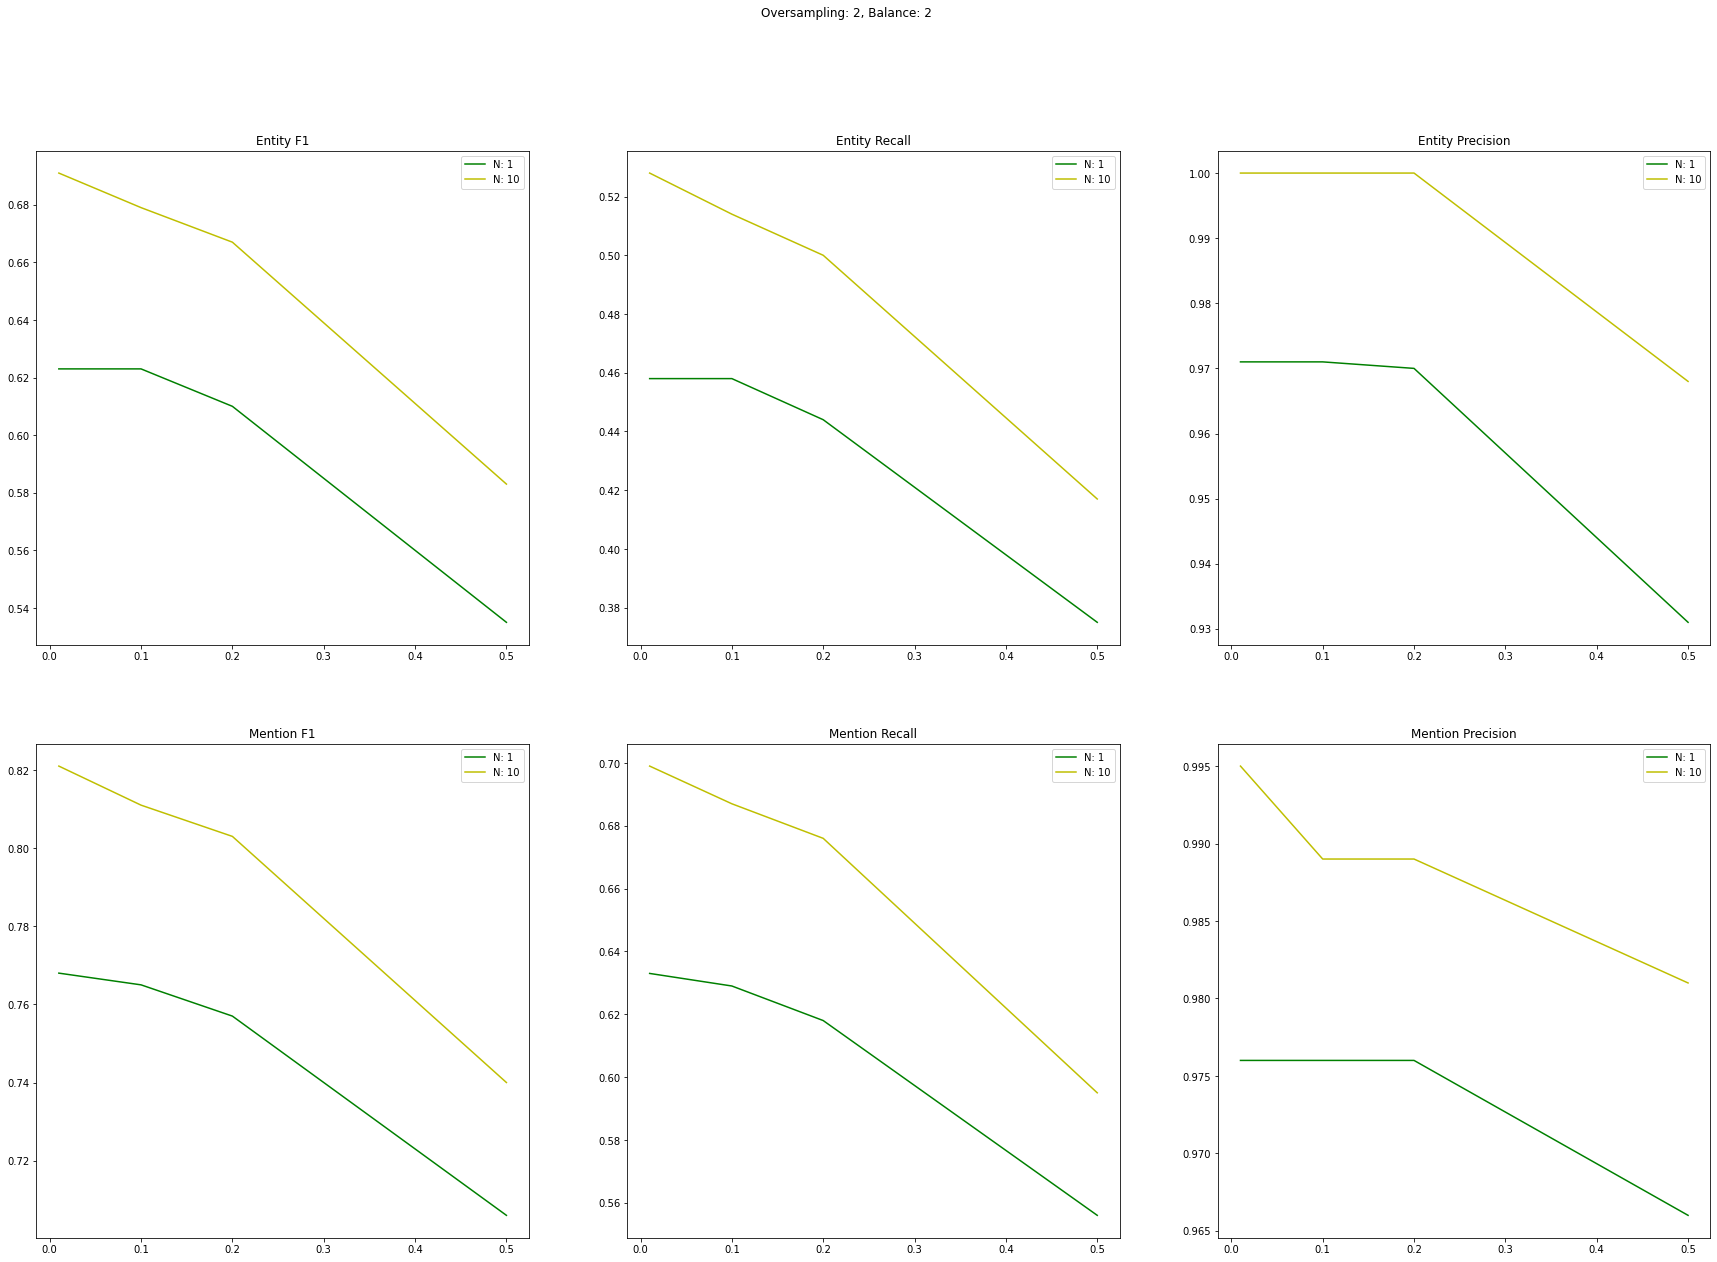

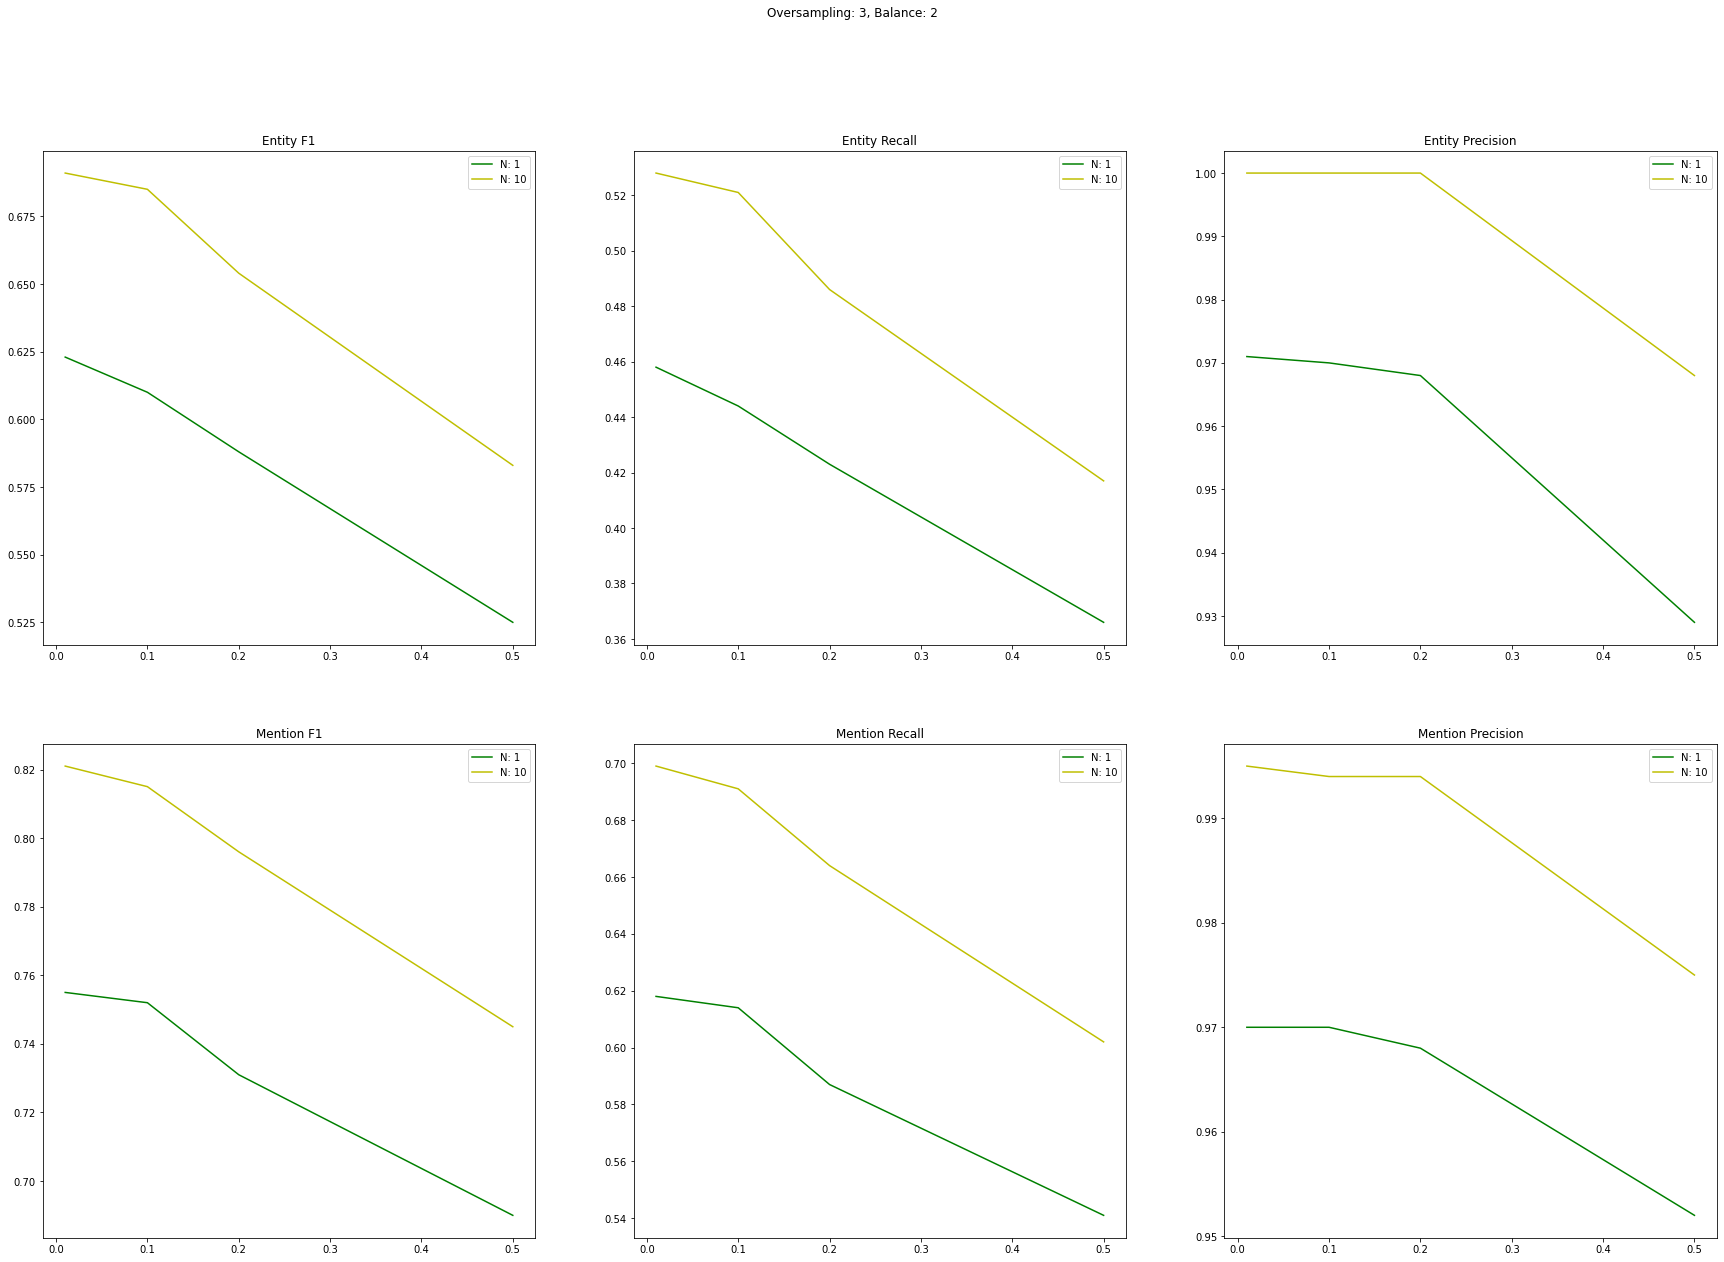

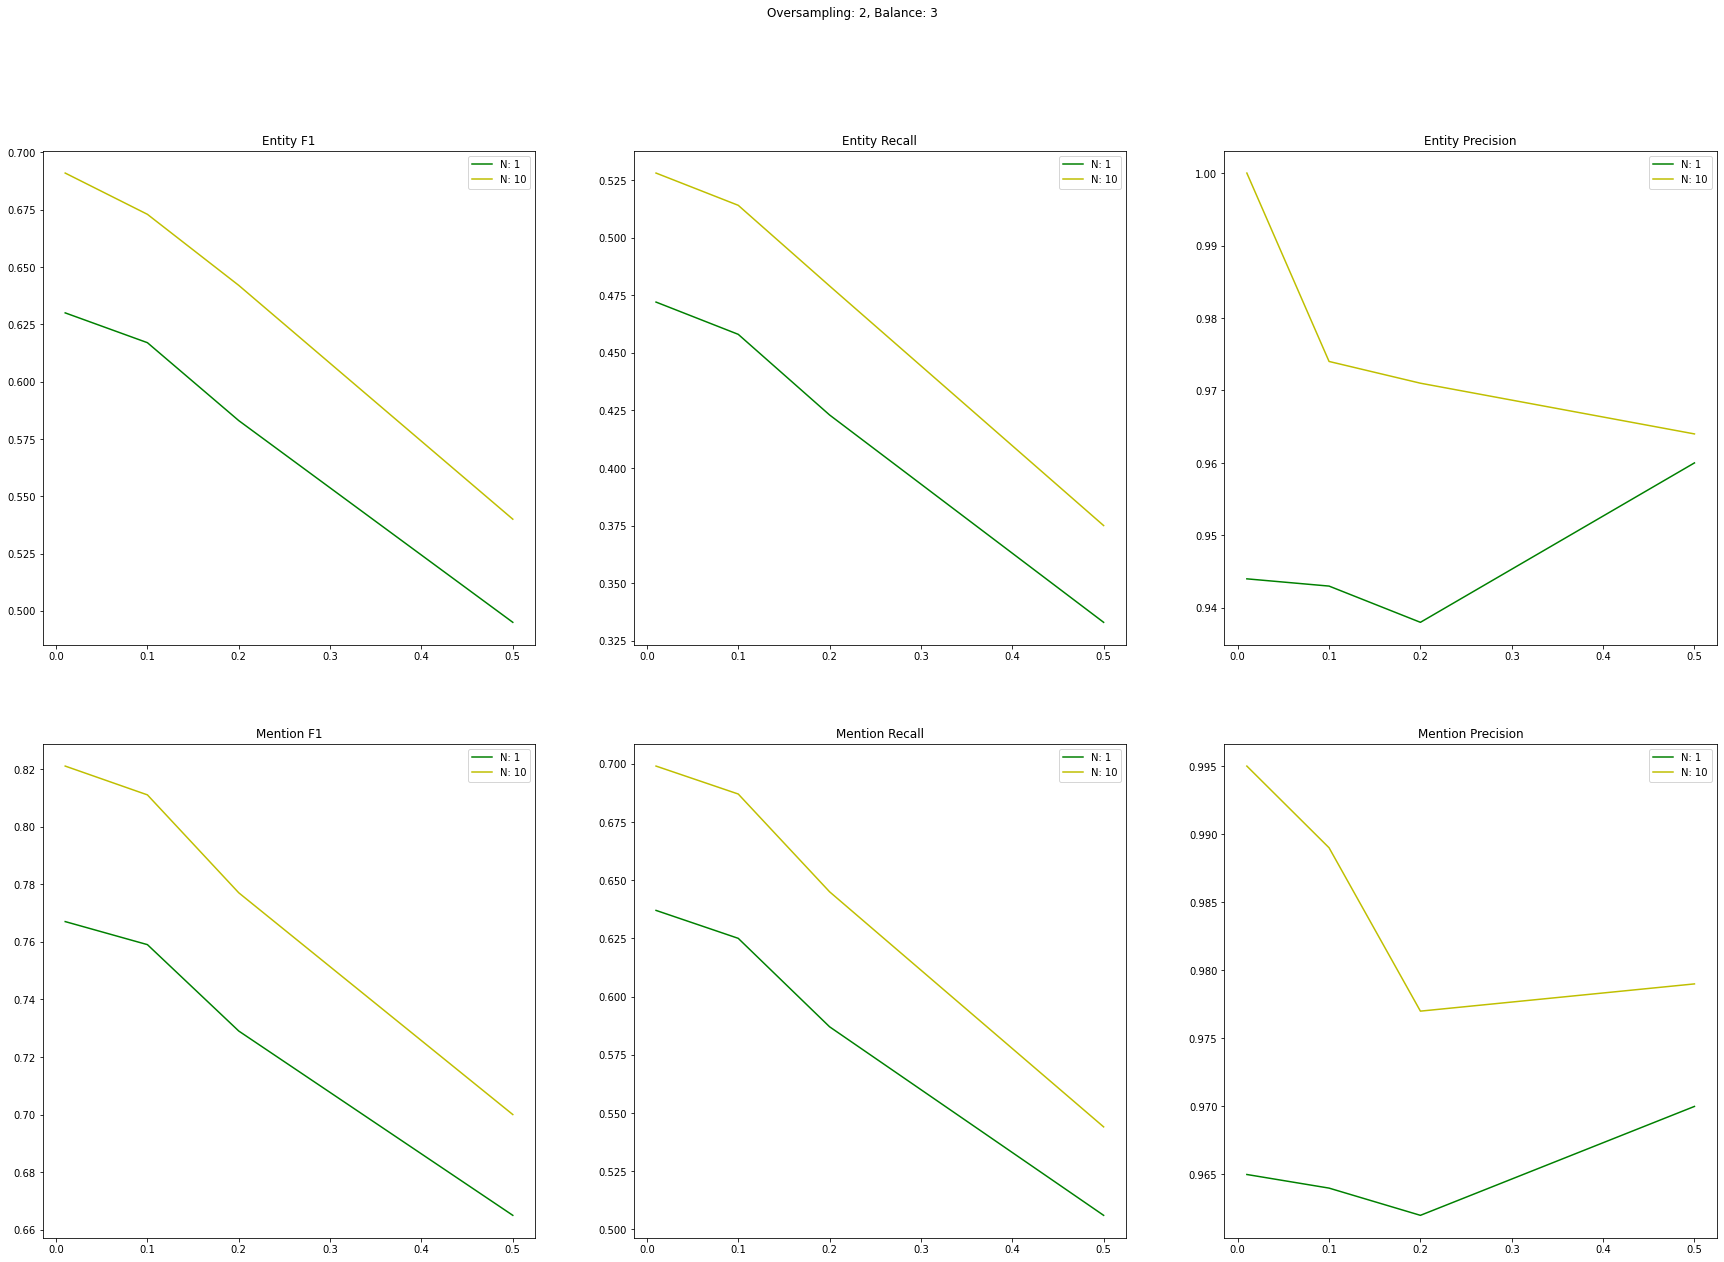

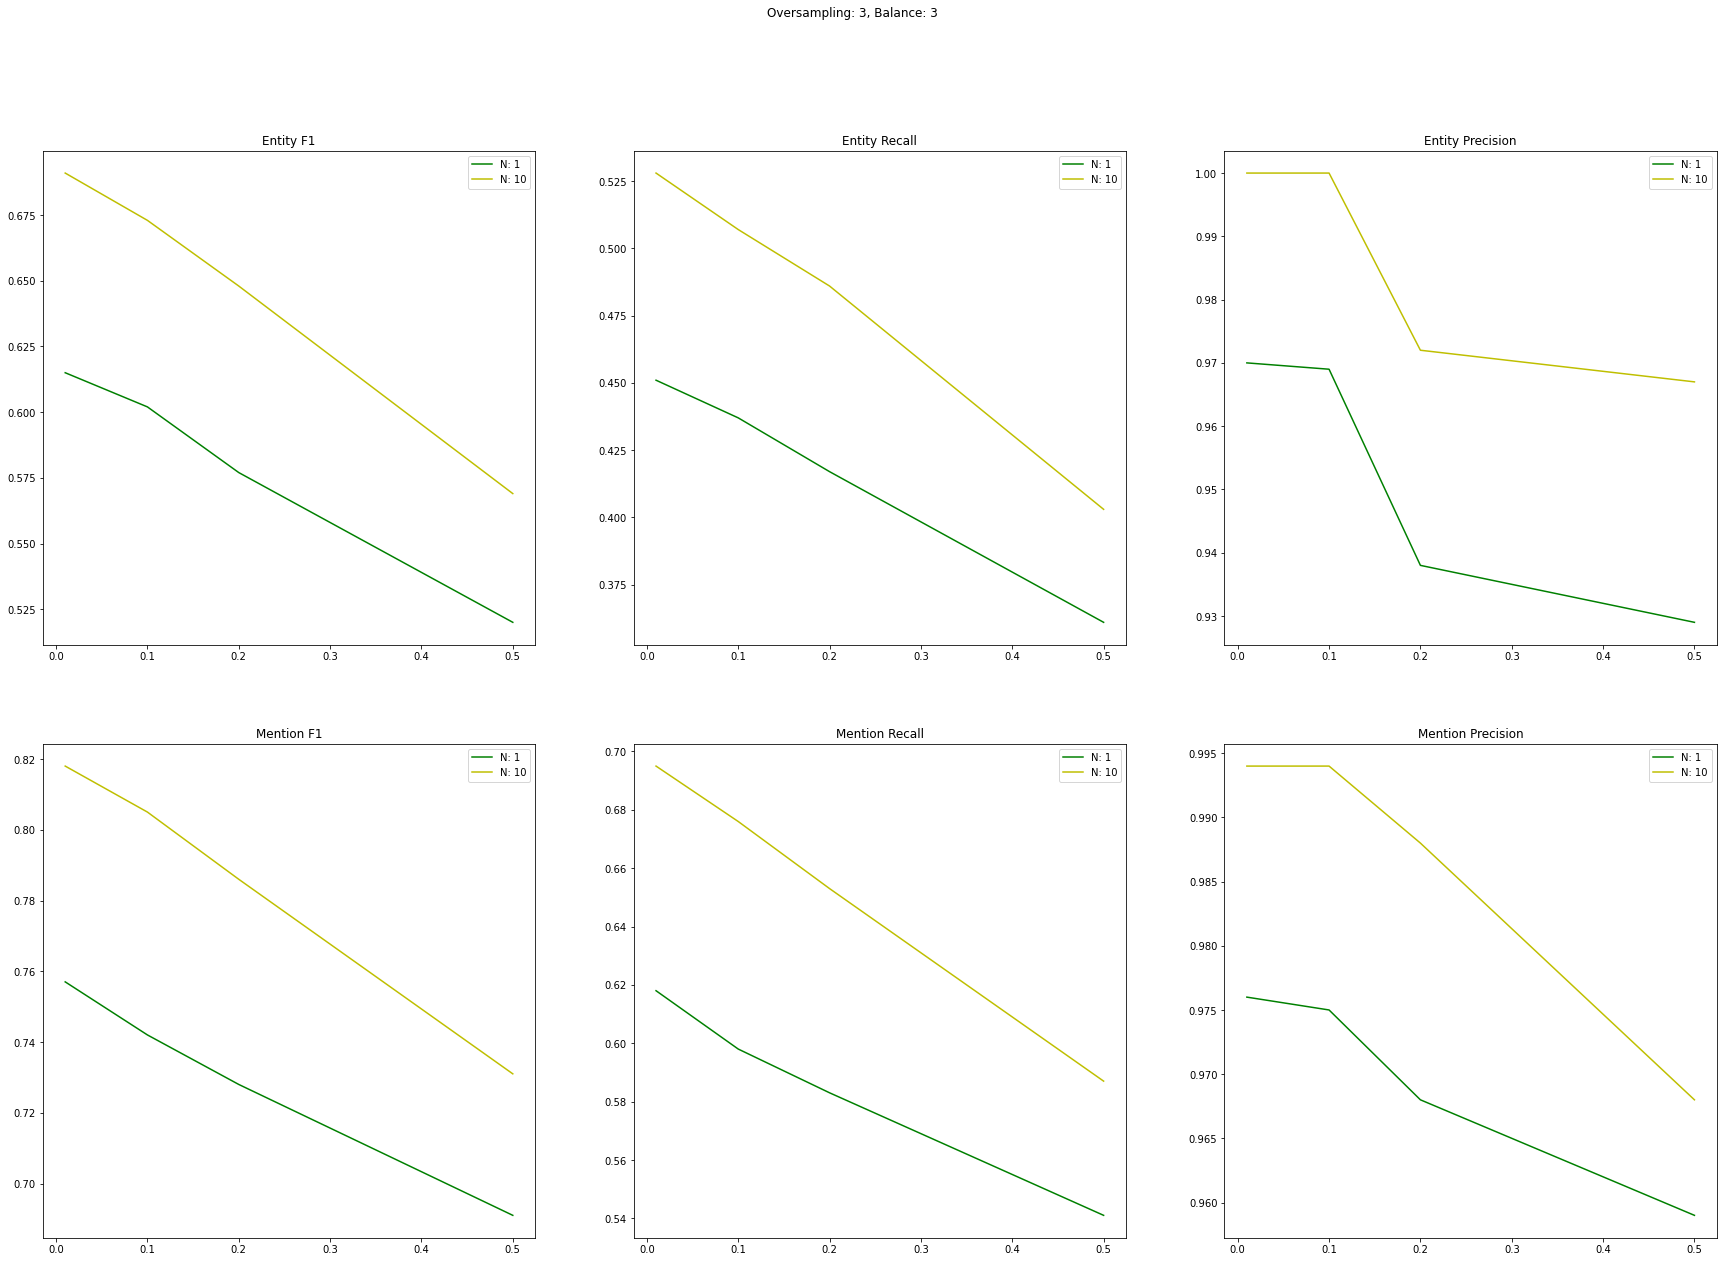

In [15]:
import os

do_sample = True
keep_empty = True
model = "Tree Reg Squared"
data = "combined"

if not os.path.exists('plots'):
    os.makedirs('plots')
    
for balance in balance_list:
    for oversampling in oversampling_list:
        plot_metrics_over_threshold(
            thresholds=thresholds, 
            n_s=n_s, 
            oversampling=oversampling, 
            balance=balance, 
            do_sample=True, 
            keep_empty=True, 
            model=model,
            data=data,
            results=results)

In [22]:
# top_10 scores are necessarily better than top_1 scores, here we can decide which one we choose to get metrics about
top_n = 1

In [23]:
def extract(scores, score_name, dict, current_setup, top_n):
    for score in scores:
        score_dict = score["score"].get_score()
        if score["top_n"] == top_n:
            curr_setup["top_n"] = score["top_n"]
            curr_setup["threshold"] = score["threshold"]
            if score_dict[score_name] > dict[f"top_{score_name}"]:
                dict[f"top_{score_name}"] = score_dict[score_name]
                dict[f"top_{score_name}_setup"] = [current_setup]
            elif score_dict[score_name] == dict[f"top_{score_name}"]:
                dict[f"top_{score_name}_setup"].append(current_setup)
    return dict

model_results = []
for model_name in model_names:
    dictionary={
        "ent": {
            "top_F1": 0,
            "top_Recall": 0,
            "top_Precision": 0,
            "top_F1_setup": [],
            "top_Recall_setup": [],
            "top_Precision_setup": []
        },
        "ment": {
            "top_F1": 0,
            "top_Recall": 0,
            "top_Precision": 0,
            "top_F1_setup": [],
            "top_Recall_setup": [],
            "top_Precision_setup": []
        }
    }
    for di in results:
        if di["model"] == model_name:
            for scoring_level in ["ent", "ment"]:
                scores = di[f"{scoring_level}_scores"]
                curr_setup = {
                    "data": di["data"],
                    "do_sample": di["do_sample"],
                    "balance": di["balance"],
                    "oversampling": di["oversampling"],
                    "keep_empty": di["keep_empty"]
                }
                for score_name in ["F1", "Recall", "Precision"]:
                    dictionary[scoring_level] = extract(scores, score_name, dictionary[scoring_level], curr_setup, top_n=top_n )
    model_results.append(dictionary)        


In [24]:
score = "F1"

In [25]:
for scores, model_name in zip(model_results, model_names):
    balance = []
    combined = []
    oversampling = []
    keep_empty = []
    do_sample = []
    top_n = []
    thresholds = []
    print(model_name)
    for scoring_level in ["ent", "ment"]:
        print(f"{scoring_level}\t", f"{score}:\t", scores[scoring_level][f"top_{score}"])
        print(f"{scoring_level}\t", f"{score} Setup:")
        for setup in scores[scoring_level][f"top_{score}_setup"]:
            if setup["data"] == "cleaned":
                combined.append(0)
            else:
                combined.append(1)
            balance.append(setup["balance"])
            oversampling.append(setup["oversampling"])
            top_n.append(setup["top_n"])
            thresholds.append(setup["threshold"])
            if setup["do_sample"]:
                do_sample.append(1)
            else:
                do_sample.append(0)
            if setup["keep_empty"]:
                keep_empty.append(1)
            else:
                keep_empty.append(0)
    
        print(f"Number of setups: {len(do_sample)}")

        print("Mean")
        print("sample", np.mean(do_sample))
        print("empty ", np.mean(keep_empty))
        print("combin", np.mean(combined))
        print("tresh ", np.mean(thresholds))
        print("top_n ", np.mean(top_n))
        print("overs ", np.mean(oversampling))
        print("balanc", np.mean(balance))

        print("Median")
        print("sample", np.median(do_sample))
        print("empty ", np.median(keep_empty))
        print("combin", np.median(combined))
        print("tresh ", np.median(thresholds))
        print("top_n ", np.median(top_n))
        print("overs ", np.median(oversampling))
        print("balanc", np.median(balance))
        print("\n\n")
            

Tree Reg Squared
ent	 F1:	 0.641
ent	 F1 Setup:
Number of setups: 1
Mean
sample 1.0
empty  1.0
combin 0.0
tresh  0.5
top_n  1.0
overs  2.0
balanc 2.0
Median
sample 1.0
empty  1.0
combin 0.0
tresh  0.5
top_n  1.0
overs  2.0
balanc 2.0



ment	 F1:	 0.779
ment	 F1 Setup:
Number of setups: 2
Mean
sample 1.0
empty  1.0
combin 0.0
tresh  0.5
top_n  1.0
overs  2.0
balanc 2.0
Median
sample 1.0
empty  1.0
combin 0.0
tresh  0.5
top_n  1.0
overs  2.0
balanc 2.0





After some tests we find:
- ExtraTreesRegressor works best
- with: 
    - Balance = 1
    - Oversampling = 1
    - do_sample = True
    - keep_empty = True
    - treshold = 0.1 or smaller is more stable in advers conditions for balance 1 and oversampling 1 it does not matter -> this makes the regression more stable
    - => n -> does not matter so much can amolst go to 1 !!!!

- problematic entities seem to help 